# Libs Import


In [27]:
%load_ext autoreload
%autoreload 2
from typing import Optional, Tuple, Literal
import os
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jr 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
from scipy.stats import spearmanr, pearsonr

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platforms', 'cpu')
%load_ext autoreload
%autoreload 2
# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.icnn_modules import ProbStackedICNNImputer, ImputerMetrics, ProbICNNImputerTrainer, ICNNObsDecoder, StandardICNNImputerTrainer
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config, append_params_to_zip, zip_members
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# ?pub_ready_plots.get_mpl_rcParams
# !pip install pub-ready-plots

In [29]:
import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True

# rc_params['font.size'] = 10
# rc_params['axes.titlesize'] = 12
# rc_params['axes.labelsize'] = 10
# rc_params['legend.fontsize'] = 10

plt.rcParams.update(rc_params)


In [30]:
rc_params

{'text.usetex': False,
 'font.size': 8,
 'font.family': 'serif',
 'font.serif': 'cmr10',
 'mathtext.fontset': 'cm',
 'lines.linewidth': 1.25,
 'axes.linewidth': 1,
 'axes.titlesize': 8,
 'axes.labelsize': 7,
 'axes.unicode_minus': False,
 'axes.formatter.use_mathtext': True,
 'legend.fontsize': 7,
 'xtick.major.size': 1,
 'ytick.major.size': 1,
 'xtick.major.width': 1,
 'ytick.major.width': 1,
 'figure.constrained_layout.use': True}

# Experiment Defnitions

In [31]:
PROB_MODELS = ('ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL', 'ICNN_KLR', 'ICNN_NKLR', 'ICNN_JSD', 'ICNN_NJSD')
DET_MODELS = ('ICNN_MSE', 'ICNN_NMSE')

EXP_DIR = {
    key: f'snapshots_{key.lower()}' for key in PROB_MODELS + DET_MODELS
}


def experiment_data(dataset_path: str):
    obs_val = pd.read_csv(f'{dataset_path}/missingness_vals.csv', index_col=[0])
    obs_mask = pd.read_csv(f'{dataset_path}/missingness_mask.csv', index_col=[0])
    artificial_mask = pd.read_csv(f'{dataset_path}/missingness_artificial_mask.csv', index_col=[0])
    return obs_val, obs_mask, artificial_mask


def experiment_model(exp: str, observables_size: int):
    pmodels = {
        k: ProbStackedICNNImputer(observables_size=observables_size, state_size=0, optimiser_name='lamb',
                                  max_steps=2 ** 9, lr=1e-2,
                                  positivity='softplus', hidden_size_multiplier=2, depth=5, key=jr.PRNGKey(0))
        for k in PROB_MODELS}
    # pmodels['ICNN_LN'] = ProbStackedICNNImputer(observables_size=observables_size, state_size=0, optimiser_name='lamb',
    #                               max_steps=2 ** 9, lr=1e-2,
    #                               positivity='clipped', hidden_size_multiplier=2, depth=5, key=jr.PRNGKey(0))

    dmodels = {k: ICNNObsDecoder(observables_size=observables_size, state_size=0, optimiser_name='lamb',
                                 max_steps=2 ** 9, lr=1e-2,
                                 positivity='softplus', hidden_size_multiplier=3, depth=5, key=jr.PRNGKey(0))
               for k in DET_MODELS}
    return (pmodels | dmodels)[exp]


def experiment_trainer(e: str):
    return {
        'ICNN_LN': ProbICNNImputerTrainer(loss='log_normal', optimiser_name='adam'),
        'ICNN_NLN': ProbICNNImputerTrainer(loss='log_normal', optimiser_name='adam', loss_feature_normalisation=True),
        'ICNN_KL': ProbICNNImputerTrainer(loss='kl_divergence', optimiser_name='adam', ),
        'ICNN_NKL': ProbICNNImputerTrainer(loss='kl_divergence', optimiser_name='adam',
                                           loss_feature_normalisation=True),
        'ICNN_KLR': ProbICNNImputerTrainer(loss='klr_divergence', optimiser_name='adam', ),
        'ICNN_NKLR': ProbICNNImputerTrainer(loss='klr_divergence', optimiser_name='adam',
                                           loss_feature_normalisation=True),
        'ICNN_JSD': ProbICNNImputerTrainer(loss='jsd_gaussian', optimiser_name='adam'),
        'ICNN_NJSD': ProbICNNImputerTrainer(loss='jsd_gaussian', optimiser_name='adam',
                                            loss_feature_normalisation=True),
        'ICNN_MSE': StandardICNNImputerTrainer(optimiser_name='adam'),
        'ICNN_NMSE': StandardICNNImputerTrainer(optimiser_name='adam', loss_feature_normalisation=True)
    }[e]

In [32]:
RESULTS_DIR = 'icnn_results_B'
EXPERIMENTS_DIR = '/home/asem/GP/ehr-data/icnn_imputation_experiments'
DATASET_PATH = '/home/asem/GP/ehr-data/missingness_data'
ICNN_RENAMES = {k: f'P-ICNN ({k.split("_")[1]})' for k in PROB_MODELS}  | {k: f'S-ICNN ({k.split("_")[1]})' for k in DET_MODELS}


EXP = 'ICNN_NMSE'
experiment_dir = f'{EXPERIMENTS_DIR}/{EXP_DIR[EXP]}'


# Data Loading

In [33]:
obs_val, obs_mask, artificial_mask = experiment_data(DATASET_PATH)
model = experiment_model(EXP, obs_val.shape[1])
trainer = experiment_trainer(EXP)

split_ratio = 0.7
seed = 0
indices = jr.permutation(jr.PRNGKey(seed), len(obs_val))
train_idx = indices[:int(split_ratio * len(indices))]
test_idx = indices[int(split_ratio * len(indices)):]

obs_val_train = jnp.array(obs_val.iloc[train_idx].to_numpy())
obs_mask_train = jnp.array(obs_mask.iloc[train_idx].to_numpy())
art_mask_train = jnp.array(artificial_mask.iloc[train_idx].to_numpy())



obs_val_test = jnp.array(obs_val.iloc[test_idx].to_numpy())
obs_mask_test = jnp.array(obs_mask.iloc[test_idx].to_numpy())
art_mask_test = jnp.array(artificial_mask.iloc[test_idx].to_numpy())

In [34]:
# cooc = obs_mask.T.dot(obs_mask)
# cooc

In [35]:

# sns.heatmap(np.log10(cooc + 1))


In [36]:
np.mean(obs_mask)

0.08695259245595174

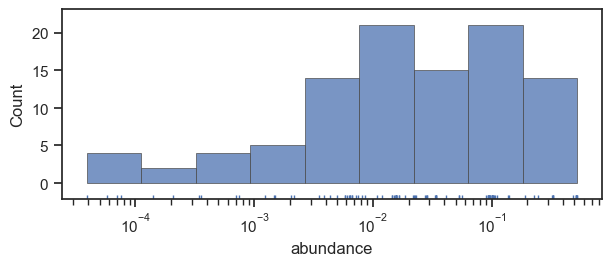

In [37]:
import matplotlib as mpl


p_mask = pd.DataFrame({'abundance': obs_mask.mean(axis=0)})


# sns.kdeplot(data=p_mask, x="abundance", log_scale=True)
# sns.rugplot(data=p_mask, x="abundance")
sns.set_theme(style="ticks")
# sns.kdeplot(data=p_mask, x="abundance", log_scale=True)
g = sns.rugplot(data=p_mask, x="abundance")
g.set_xscale('log')

sns.histplot(
    p_mask,
    x="abundance", 
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
g.get_figure().set_size_inches(fig_width_in, fig_height_in * 1.5)
g.get_figure().savefig(f"{RESULTS_DIR}/features_abundance.pdf")


In [12]:
obs_mask.shape

(693898, 100)

In [13]:
# zip_members(f'{EXP_DIR}/params.zip')

### Dump Training Statistics

In [14]:
# FIRST TIME - BEGIN 

# train_stats = pd.DataFrame(train_history)
# test_stats = pd.DataFrame(test_history)

# train_stats['split'] = 'Train'
# train_stats['iteration'] = train_stats.index + 1
# test_stats['split'] = 'Test'
# test_stats['iteration'] = (test_stats.index * eval_frequency) + 1
# training_stats = pd.concat([train_stats, test_stats])
# training_stats_melted = pd.melt(training_stats, value_vars=['loss'], id_vars=['split', 'iteration'], value_name='Loss')
# training_stats_melted = training_stats_melted.astype({'Loss': float})

# training_stats.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv')  
# training_stats_melted.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv')  

# FIRST TIME - END 


# LATER TIMES
# training_stats = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv', index_col=[0])  
# training_stats_melted = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv', index_col=[0])  



# g2 = sns.lineplot(data=training_stats_melted, x="iteration", y="Loss", hue="split")
# g2.get_figure().set_size_inches(fig_width_in, fig_height_in)
# g2.get_figure().savefig(f"{RESULTS_DIR}/{EXP}_training_stats.pdf")

## Sklearn Training

In [38]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

sklearn_imputers =  {
    'zero_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    'mean_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn_imputer': lambda: KNNImputer(missing_values=np.nan),
    'iter_imputer': lambda: IterativeImputer(
        missing_values=np.nan,
        add_indicator=False,
        random_state=0,
        n_nearest_features=5,
        max_iter=5,
        sample_posterior=True,
    )
}

# sklearn_trained_imputers = {k: v().fit(np.where(obs_mask_train, obs_val_train, np.nan)) for k, v in sklearn_imputers.items()} 

# Metrics / Results

In [39]:
prediction_mask = (1 - art_mask_test) * obs_mask_test
feature2index =  dict(zip(obs_val.columns, range(len(obs_val.columns))))
n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)
n_test = ((1 - art_mask_test) * obs_mask_test).sum(axis=0)
n_train_measured = obs_mask_train.sum(axis=0)
missingness = 1 - obs_mask.mean(axis=0)
validation_missingness = 1 - pd.DataFrame(art_mask_test, columns=obs_mask.columns).mean(axis=0)

In [40]:
n_test_censored = pd.Series(prediction_mask.sum(axis=0), index=obs_val.columns)
p_test_censored = n_test_censored / len(prediction_mask)
vars_n300 = n_test_censored[n_test_censored >= 300].index
vars_n300_r = n_test_censored[n_test_censored < 300].index
vars_n300, len(vars_n300)

(Index(['blood_chemistry.albumin', 'blood_chemistry.aniongap',
        'blood_chemistry.bicarbonate', 'blood_chemistry.bun',
        'blood_chemistry.calcium', 'blood_chemistry.chloride',
        'blood_chemistry.creatinine', 'blood_chemistry.glucose',
        'blood_chemistry.potassium', 'blood_chemistry.sodium',
        'blood_diff.basophils', 'blood_diff.basophils_abs',
        'blood_diff.eosinophils', 'blood_diff.eosinophils_abs',
        'blood_diff.lymphocytes', 'blood_diff.lymphocytes_abs',
        'blood_diff.monocytes', 'blood_diff.monocytes_abs',
        'blood_diff.neutrophils', 'blood_diff.neutrophils_abs',
        'blood_gas.aado2_calc', 'blood_gas.baseexcess', 'blood_gas.calcium',
        'blood_gas.fio2_chartevents', 'blood_gas.glucose', 'blood_gas.lactate',
        'blood_gas.pao2fio2ratio', 'blood_gas.pco2', 'blood_gas.ph',
        'blood_gas.po2', 'blood_gas.potassium', 'blood_gas.totalco2',
        'cardiac_marker.ck_mb', 'cardiac_marker.troponin_t2', 'cbc.hematocri

In [41]:
variable_map = {'blood_chemistry.albumin': 'Albumin',  'blood_chemistry.aniongap': 'Aniongap',  
                'blood_chemistry.bicarbonate': 'bc.Bicarbonate',  'blood_chemistry.bun': 'Urea Nitrogen', 
                'blood_chemistry.calcium': 'bc.Calcium',  'blood_chemistry.chloride': 'bc.Chloride',  
                'blood_chemistry.creatinine': 'bc.Creatinine',  'blood_chemistry.globulin': 'Globulin',  
                'blood_chemistry.glucose': 'bc.Glucose',  'blood_chemistry.potassium': 'bc.Potassium',  
                'blood_chemistry.sodium': 'bc.Sodium',  'blood_chemistry.total_protein': 'Protein Total', 
                'blood_diff.atypical_lymphocytes': 'Atypical Lymphocytes',  'blood_diff.bands': 'Bands (%)',  
                'blood_diff.basophils': 'Basophils',  'blood_diff.basophils_abs': 'Abs Basophils', 
                'blood_diff.eosinophils': 'Eosinophils',  'blood_diff.eosinophils_abs': 'Abs Eosinophils', 
                'blood_diff.immature_granulocytes': 'Immature Granulocytes',  'blood_diff.lymphocytes': 'Lymphocytes',
                'blood_diff.lymphocytes_abs': 'Abs Lymphocytes',  'blood_diff.metamyelocytes': 'Metamyelocytes', 
                'blood_diff.monocytes': 'Monocytes',  'blood_diff.monocytes_abs': 'Abs Monocytes', 
                'blood_diff.neutrophils': 'Neutrophils',  'blood_diff.neutrophils_abs': 'Abs Neutrophil', 
                'blood_diff.nrbc': 'NRBC',  'blood_gas.aado2': 'AaDO2',  'blood_gas.aado2_calc': 'AaDO2_calc',
                'blood_gas.baseexcess': 'Base excess',  'blood_gas.bicarbonate': 'bg.Bicarbonate',  'blood_gas.calcium': 'bg.Calcium',  
                'blood_gas.carboxyhemoglobin': 'Carboxyhemoglobin',  'blood_gas.chloride': 'bg.Chloride',  'blood_gas.fio2': 'FiO2',  
                'blood_gas.fio2_chartevents': 'FiO2_chartevents',  'blood_gas.glucose': 'bg.Glucose',  
                'blood_gas.hematocrit': 'bg.Hematocrit',  'blood_gas.hemoglobin': 'bg.Hemoglobin',  'blood_gas.lactate': 'Lactate', 
                'blood_gas.methemoglobin': 'Methemoglobin',  'blood_gas.pao2fio2ratio': 'pO2/FiO2 ratio',  'blood_gas.pco2': 'pCO2',
                'blood_gas.ph': 'pH',  'blood_gas.po2': 'pO2',  'blood_gas.potassium': 'bg.Potassium',  'blood_gas.so2': 'sO2', 
                'blood_gas.sodium': 'bg.Sodium',  'blood_gas.temperature': 'bg.Temperature',  'blood_gas.totalco2': 'CO2 total', 
                'cardiac_marker.ck_mb': 'Creatinine Kinase, MB',  'cardiac_marker.ntprobnp': 'NT-proBNP', 
                'cardiac_marker.troponin_t2': 'Troponin T',  'cbc.hematocrit': 'cbc.Hematocrit',  'cbc.hemoglobin': 'cbc.Hemoglobin', 
                'cbc.mch': 'MCH',  'cbc.mchc': 'MCHC',  'cbc.mcv': 'MCV',  'cbc.platelet': 'Platelet',  'cbc.rbc': 'RBC', 
                'cbc.rdw': 'RDW',  'cbc.wbc': 'WBC',  'coagulation.d_dimer': 'D-Dimer',  'coagulation.fibrinogen': 'Fibrinogen', 
                'coagulation.inr': 'INR',  'coagulation.pt': 'PT',  'coagulation.ptt': 'PTT',  'coagulation.thrombin': 'Thrombin',
                'enzymes.alp': 'ALP',  'enzymes.alt': 'ALT',  'enzymes.amylase': 'Amylase',  'enzymes.ast': 'AST', 
                'enzymes.bilirubin_direct': 'Bilirubin direct',  'enzymes.bilirubin_indirect': 'Bilirubin indirect',
                'enzymes.bilirubin_total': 'Bilirubin total',  'enzymes.ck_cpk': 'CK-CPK',  'enzymes.ck_mb':'CK-MB', 
                'enzymes.ggt': 'GGT',  'enzymes.ld_ldh': 'ld_ldh',  'icp.icp': 'Intra-cranial Press.',
                'inflammation.crp': 'CRP',  'renal_aki.aki_binary': 'AKI (binary)',  'renal_aki.aki_stage_smoothed': 'AKI', 
                'renal_creat.creat': 'renal.Creatinine',  'renal_out.uo_rt_12hr': 'Urine out 12h',  'renal_out.uo_rt_24hr': 'Urine out 24h',
                'renal_out.uo_rt_6hr': 'Urine out 6h',  'sofa.sofa_24hours': 'SOFA',  'vital.dbp': 'Diastolic BP', 
                'vital.dbp_ni': 'NI-Diastolic BP',  'vital.glucose': 'vital.Glucose',  'vital.heart_rate': 'Heart Rate',  
                'vital.mbp':  'Mean BP',  'vital.mbp_ni': 'NI Mean BP',  'vital.resp_rate': 'Respiratory Rate', 
                'vital.sbp': 'Systolic BP',  'vital.sbp_ni':  'NI-Systolic BP',  'vital.spo2': 'SpO2',  
                'vital.temperature': 'vital.Temperature',  'weight.weight': 'Weight'}

## Metrics Evolution with ICNN Training

In [42]:
# FIRST TIME - BEGIN 

# dataframes = []
# for step, model_snap in tqdm(model_snapshots.items()):
#     with jax.default_device(jax.devices("cpu")[0]):
#         obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#         (X_test_imp, X_test_std), _ = eqx.filter_vmap(model_snap.prob_partial_input_optimise)(obs_test, art_mask_test)
    
#     sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
#     r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                           for t in sigma_threshold]
    
#     r2_test_results = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
#     r2_test_results['sigma_threshold'] = sigma_threshold
#     r2_test_results['step'] = step
#     dataframes.append(r2_test_results)

# r2_iters_test_results = pd.concat(dataframes)
# r2_iters_test_results = pd.melt(r2_iters_test_results, value_vars=list(obs_val.columns), id_vars=['sigma_threshold', 'step'], value_name='R2')

# r2_iters_test_results.to_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv')
# FIRST TIME - END 
# r2_iters_test_results = pd.read_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv', index_col=[0])

In [20]:
# r2_iters_test_results

## Metrics of the Last ICNN Snapshot

### Inference with Last ICNN Snapshot (one-time)

In [21]:
# FIRST TIME - BEGIN 
# model = model.load_params_from_archive(f'{EXP_DIR[EXP]}/params.zip', 'step9999.eqx')
# with jax.default_device(jax.devices("cpu")[0]):
#     obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#     (X_test_imp, X_test_std), _ = eqx.filter_vmap(model.prob_partial_input_optimise)(obs_test, art_mask_test)

# X_test_imp_df = pd.DataFrame(X_test_imp, columns=obs_val.columns)
# X_test_std_df = pd.DataFrame(X_test_std, columns=obs_val.columns)

# X_test_imp_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_imp.csv')
# X_test_std_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_std.csv')
# FIRST TIME - END 

### Ablation Study - Optimiser / max_steps

In [16]:
# model =  experiment_model(EXP, obs_val_test.shape[1])
# # model = model.load_params_from_archive(f'{experiment_dir}/params.zip', 'step9999.eqx')

# sample_index = jr.choice(jr.PRNGKey(42), a=len(art_mask_test), shape=(500,))
# sample_obs_test = jnp.where(art_mask_test[sample_index], obs_val_test[sample_index], 0.)
# sample_art_mask_test = art_mask_test[sample_index]
# energy0 = eqx.filter_vmap(model.f_energy)(sample_obs_test)

# with jax.default_device(jax.devices("cpu")[0]):
#     energy = {}
#     total_steps = {}
#     for opt in tqdm(('bfgs', 'nonlinear_cg'), leave=False):
#         model = eqx.tree_at(lambda m: m.optimiser_name, model, opt)
#         for max_steps_exp in tqdm((8, 9, 10, 11), leave=False):
#             model = eqx.tree_at(lambda m: m.max_steps, model, 2**max_steps_exp)
#             _, stats = eqx.filter_vmap(model.partial_input_optimise)(sample_obs_test, sample_art_mask_test)
#             energy[(opt, float('nan'), max_steps_exp)] = stats.energy
#             total_steps[(opt, float('nan'), max_steps_exp)] = stats.n_steps
            
#     for opt in tqdm(('adam', 
#                      'polyak_sgd', 
#                      'lamb', 
#                      'yogi',
#                ), leave=False):
#         for lr in tqdm((1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5), leave=False):
#             for max_steps_exp in tqdm((8, 9, 10, 11), leave=False):
#                 model = eqx.tree_at(lambda m: m.optimiser_name, model, opt)
#                 model = eqx.tree_at(lambda m: m.max_steps, model, 2**max_steps_exp)
#                 model = eqx.tree_at(lambda m: m.lr, model, lr)

#                 _, stats = eqx.filter_vmap(model.partial_input_optimise)(sample_obs_test, sample_art_mask_test)
#                 energy[(opt, lr, max_steps_exp)] = stats.energy
#                 total_steps[(opt, lr, max_steps_exp)] = stats.n_steps

# data = defaultdict(list)

# for ((opt, lr, max_steps_exp), energy_vec), total_steps_vec in zip(energy.items(), total_steps.values()):
#     data['opt'].extend([opt] * len(energy_vec))
#     data['max_steps_exp'].extend([max_steps_exp] * len(energy_vec))
#     data['lr'].extend([lr] * len(energy_vec))
#     data['E'].extend((energy_vec).tolist())
#     data['delta_E'].extend((energy0 - energy_vec).tolist())
#     data['n_steps'].extend(total_steps_vec.tolist())

# energy_df = pd.DataFrame(data)
# energy_df['max_steps'] = 2 ** energy_df['max_steps_exp']

# energy_df['early_terminate'] = energy_df['n_steps'] < energy_df['max_steps']

# energy_df.to_csv(f"delta_E_{EXP}_untrained.csv")
# # energy_df.to_csv(f"delta_E_{EXP}_trained.csv")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
# EXP = 'ICNN_NLN'

# energy_trained_df = pd.read_csv(f"delta_E_{EXP}_trained.csv")
# energy_untrained_df = pd.read_csv(f'delta_E_{EXP}_untrained.csv')
# energy_trained_df['sample_index'] = list(range(500)) * (len(energy_trained_df) // 500)
# energy_untrained_df['sample_index'] = list(range(500)) * (len(energy_untrained_df) // 500)

# energy_trained_df['early_terminate'] = energy_trained_df['n_steps'] < energy_trained_df['max_steps']
# energy_untrained_df['early_terminate'] = energy_untrained_df['n_steps'] < energy_untrained_df['max_steps']

# energy_trained_df['log_delta_E'] = np.log(energy_trained_df['delta_E'])
# energy_untrained_df['log_delta_E'] = np.log(energy_untrained_df['delta_E'])


# energy_trained_df['max_delta_E'] = energy_trained_df.sample_index.map(energy_trained_df.groupby('sample_index')['delta_E'].max())
# energy_untrained_df['max_delta_E'] = energy_untrained_df.sample_index.map(energy_untrained_df.groupby('sample_index')['delta_E'].max())

# energy_trained_df['delta_E_ratio'] = energy_trained_df['delta_E'] / energy_trained_df['max_delta_E']
# energy_untrained_df['delta_E_ratio'] = energy_untrained_df['delta_E'] / energy_untrained_df['max_delta_E']

# energy_trained_df['log_delta_E_ratio'] = np.log(energy_trained_df['delta_E_ratio'])
# energy_untrained_df['log_delta_E_ratio'] = np.log(energy_untrained_df['delta_E_ratio'])


# energy_trained_df['min_E'] = energy_trained_df.sample_index.map(energy_trained_df.groupby('sample_index')['E'].min())
# energy_untrained_df['min_E'] = energy_untrained_df.sample_index.map(energy_untrained_df.groupby('sample_index')['E'].min())

# energy_trained_df['E_l1'] = energy_trained_df['E'] - energy_trained_df['min_E']
# energy_trained_df['E_l2'] = (energy_trained_df['E'] - energy_trained_df['min_E'])**2


# energy_untrained_df['E_l1'] = energy_untrained_df['E'] - energy_untrained_df['min_E']
# energy_untrained_df['E_l2'] = (energy_untrained_df['E'] - energy_untrained_df['min_E'])**2


In [22]:
# energy_untrained_df.groupby(['opt', 'max_steps', 'lr'])[['early_terminate']].mean().transpose().to_csv(f"early_terminate_{EXP}_untrained.csv")
# energy_trained_df.groupby(['opt', 'max_steps', 'lr'])[['early_terminate']].mean().transpose().to_csv(f"early_terminate_{EXP}_trained.csv")

In [77]:
# energy_untrained_df.groupby(['opt', 'max_steps', 'lr'])[['log_delta_E_ratio']].mean().transpose().to_csv(f"opt_max_steps_{EXP}_untrained.csv")

In [43]:
# from bokeh.io import curdoc
# from bokeh.layouts import column, gridplot
# from bokeh.core.enums import MarkerType
# from bokeh.models import Div, Legend
# from bokeh.palettes import Spectral
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook, export_svgs, export_png
# output_notebook()

# def plot_opt(dataframe, opt_name):
#     opt_df = dataframe[energy_trained_df.opt == opt_name]
#     p = figure(width=400, height=400, 
#                toolbar_location=None,
#                output_backend='svg',
#               title=opt_name)
#     palette = Spectral[dataframe.lr.nunique(dropna=False)]
#     dash_style = ["solid", "dashed", "dotted", "dotdash", "dashdot"]
#     max_steps = dataframe.max_steps_exp.unique()

#     if opt_df.lr.nunique(dropna=False) > 1:
#         for i, (lr, opt_lr_df) in enumerate(opt_df.groupby(['lr'])):
#             log_delta_E_ratio_avg = opt_lr_df.groupby(['max_steps_exp'])['delta_E_ratio'].mean()
#             p.line(max_steps, log_delta_E_ratio_avg, line_width=4,
#                    legend_label=f"learning_rate={lr[0]:5f}".rstrip('0'), 
#                    line_dash=dash_style[i],
#                    line_color=palette[i+1]
#                   )
#             p.scatter(max_steps, log_delta_E_ratio_avg, 
#                       marker=list(MarkerType)[i+1], size=14,
#                       line_color="navy", fill_color=palette[i+1], 
#                   )
#         p.legend.items = list(reversed(p.legend.items))
#         p.legend.visible=False 
#         p.legend.location = 'right'
#     else:
#         log_delta_E_ratio_avg = opt_df.groupby(['max_steps_exp'])['delta_E_ratio'].mean()
#         p.line(max_steps, log_delta_E_ratio_avg, line_width=4,
#                line_dash=dash_style[0],
#                line_color=palette[0])
#         p.scatter(max_steps, log_delta_E_ratio_avg, 
#                       marker=list(MarkerType)[1], size=14,
#                       line_color="navy", fill_color=palette[0], 
#                   )
            
        
#     p.xaxis.ticker = max_steps
#     p.xaxis.major_label_overrides = {e: rf"\[2^{{{e}}}\]" 
#                                      for e in max_steps} 
#     p.y_range.start = 0#-12
#     p.y_range.end = 1.1#0.5
    
#     p.yaxis.axis_label = r"$$ \Delta E / \Delta E_\text{max} $$"
#     p.xaxis.axis_label = "max steps"

#     p.xaxis.axis_label_text_font_size = "14pt"
#     p.yaxis.axis_label_text_font_size = "14pt"
    
#     p.xaxis.major_label_text_font_size = "10pt"
#     p.yaxis.major_label_text_font_size = "12pt"
#     return p

# def plot_opts(dataframe):
#     ncg_p = plot_opt(dataframe, 'nonlinear_cg')
#     bfgs_p = plot_opt(dataframe, 'bfgs')
#     lamp_p = plot_opt(dataframe, 'lamb')
#     adam_p = plot_opt(dataframe, 'adam')
#     yogi_p = plot_opt(dataframe, 'yogi')
#     polyak_p = plot_opt(dataframe, 'polyak_sgd')

#     # bfgs_p.add_layout(polyak_p.legend.clone(), 'center')
#     polyak_p.legend.visible = True
    
#     curdoc().theme = 'contrast'
    
#     grid = gridplot([[ncg_p, bfgs_p], [lamp_p, adam_p], [yogi_p, polyak_p]], 
#                     toolbar_location=None)
#     return grid
    
# grid = plot_opts(energy_trained_df)
# show(grid)
# export_png(grid, filename=f"opt_max_steps_{EXP}_trained.png")


### Visualise 2D Optimisation

In [256]:
EXP

'ICNN_NMSE'

In [397]:
EXP = 'ICNN_NMSE'

model =  experiment_model(EXP, obs_val_test.shape[1])

model = model.load_params_from_archive(f'{EXPERIMENTS_DIR}/{EXP_DIR[EXP]}/params.zip', 'step9999.eqx')

In [398]:
sample_index = jr.choice(jr.PRNGKey(42), a=len(art_mask_test), shape=(500,))
sample_obs_test = jnp.where(art_mask_test[sample_index], obs_val_test[sample_index], 0.)
sample_art_mask_test = art_mask_test[sample_index]

In [399]:
semi_full_sample_index = np.argsort(obs_mask_test.sum(axis=1))[-50:]

In [402]:
[np.array(obs_mask.columns)[np.nonzero(obs_mask_test[i])].tolist() for i in semi_full_sample_index]
sample_obs = obs_val_test[semi_full_sample_index[0]]
sample_mask = obs_mask_test[semi_full_sample_index[0]]
x_imputed, _ = model.partial_input_optimise(sample_obs,  sample_mask)

# (x_imputed, std_imputed), _ = model.prob_partial_input_optimise(sample_obs,  sample_mask)

In [403]:
obs_mask.columns[np.nonzero(sample_mask)]

Index(['blood_chemistry.albumin', 'blood_chemistry.aniongap',
       'blood_chemistry.bicarbonate', 'blood_chemistry.bun',
       'blood_chemistry.calcium', 'blood_chemistry.chloride',
       'blood_chemistry.creatinine', 'blood_chemistry.glucose',
       'blood_chemistry.potassium', 'blood_chemistry.sodium',
       'blood_diff.basophils', 'blood_diff.basophils_abs',
       'blood_diff.eosinophils', 'blood_diff.eosinophils_abs',
       'blood_diff.immature_granulocytes', 'blood_diff.lymphocytes',
       'blood_diff.lymphocytes_abs', 'blood_diff.monocytes',
       'blood_diff.monocytes_abs', 'blood_diff.neutrophils',
       'blood_diff.neutrophils_abs', 'cbc.hematocrit', 'cbc.hemoglobin',
       'cbc.mch', 'cbc.mchc', 'cbc.mcv', 'cbc.platelet', 'cbc.rbc', 'cbc.rdw',
       'cbc.wbc', 'coagulation.inr', 'coagulation.pt', 'coagulation.ptt',
       'enzymes.alp', 'enzymes.alt', 'enzymes.ast',
       'enzymes.bilirubin_indirect', 'enzymes.bilirubin_total',
       'enzymes.ck_cpk', 'enzymes.

In [404]:
# feature_i_name, feature_j_name = 'blood_chemistry.creatinine', 'blood_chemistry.bun'
feature_i_name, feature_j_name = 'blood_diff.lymphocytes', 'blood_chemistry.calcium'


# feature_i_name, feature_j_name =  'blood_gas.temperature', 'inflammation.crp'	#-0.705869433419654
# feature_i_name, feature_j_name =  'renal_out.uo_rt_12hr',  'renal_out.uo_rt_24hr'

feature_i, feature_j = feature2index[feature_i_name], feature2index[feature_j_name]
feature_i, feature_j

(19, 4)

In [405]:
obs_mask.mean().iloc[[feature_i, feature_j]]

blood_diff.lymphocytes     0.014969
blood_chemistry.calcium    0.089401
dtype: float64

In [406]:
feature_i_grid = jnp.linspace(obs_val.iloc[:, feature_i].min(), obs_val.iloc[:, feature_i].max(), 50)
feature_j_grid = jnp.linspace(obs_val.iloc[:, feature_j].min(), obs_val.iloc[:, feature_j].max(), 50)

In [407]:
def energy_2d(model, fixed_point, dim_i, dim_j, grid_i, grid_j):
    # mask2d = jnp.ones_like(fixed_point).at[[dim_i, dim_j]].set(0)
    energy2d = np.zeros((len(grid_i), len(grid_j)))
    for i, row_i in enumerate(grid_i):
        for j, row_j in enumerate(grid_j):
            point = fixed_point.at[dim_i].set(row_i).at[dim_j].set(row_j)
            energy2d[i, j] = model.f_energy(point)
    return energy2d.T

def imp_i_given_j(model, dim_i, dim_j, grid_j):
    mask2d = jnp.zeros((model.observables_size,)).at[dim_j].set(1)
    fixed_point = jnp.zeros((model.observables_size,))
    
    x_i = np.zeros((len(grid_j)))
    energy = np.zeros((len(grid_j)))
    for j, row_j in enumerate(grid_j):
        point = fixed_point.at[dim_j].set(row_j)
        x_imp, stat = model.partial_input_optimise(point, mask2d)
        x_i[j] = x_imp[dim_i]
        energy[j] = stat.energy

    return x_i, energy

def imp_i_given_j_fixed_point(model, fixed_point, dim_i, dim_j, grid_j):
    mask2d = jnp.ones((model.observables_size,)).at[dim_i].set(0)    
    x_i = np.zeros((len(grid_j)))
    for j, row_j in enumerate(grid_j):
        point = fixed_point.at[dim_j].set(row_j)
        x_imp, _ = model.partial_input_optimise(point, mask2d)
        x_i[j] = x_imp[dim_i]
    return x_i

def prob_imp_i_given_j(model, dim_i, dim_j, grid_j):
    mask2d = jnp.zeros((model.observables_size // 2,)).at[dim_j].set(1)
    fixed_point = jnp.zeros((model.observables_size // 2,))
    
    x_i = np.zeros((len(grid_j)))
    energy = np.zeros((len(grid_j)))
    for j, row_j in enumerate(grid_j):
        point = fixed_point.at[dim_j].set(row_j)
        x_imp, stat = model.partial_input_optimise(point, mask2d)
        x_i[j] = x_imp[dim_i]
        energy[j] = stat.energy

    return x_i, energy

def prob_imp_i_given_j_fixed_point(model, fixed_point, dim_i, dim_j, grid_j):
    mask2d = jnp.ones((model.observables_size // 2,)).at[dim_i].set(0)    
    x_i = np.zeros((len(grid_j)))
    for j, row_j in enumerate(grid_j):
        point = fixed_point.at[dim_j].set(row_j)
        x_imp, _ = model.partial_input_optimise(point, mask2d)
        x_i[j] = x_imp[dim_i]
    return x_i

In [408]:
E2d = energy_2d(model, x_imputed, feature_i, feature_j, feature_i_grid, feature_j_grid)
xi_given_xj, Ei_given_xj = imp_i_given_j(model, feature_i, feature_j, feature_j_grid)
xj_given_xi, Ej_given_xi = imp_i_given_j(model, feature_j, feature_i, feature_i_grid)

xi_given_xj_F = imp_i_given_j_fixed_point(model, x_imputed, feature_i, feature_j, feature_j_grid)
xj_given_xi_F = imp_i_given_j_fixed_point(model, x_imputed, feature_j, feature_i, feature_i_grid)

In [409]:
# xi_given_xj, Ei_given_xj = prob_imp_i_given_j(model, feature_i, feature_j, feature_j_grid)
# xj_given_xi, Ej_given_xi = prob_imp_i_given_j(model, feature_j, feature_i, feature_i_grid)

# xi_given_xj_F = prob_imp_i_given_j_fixed_point(model, x_imputed, feature_i, feature_j, feature_j_grid)
# xj_given_xi_F = prob_imp_i_given_j_fixed_point(model, x_imputed, feature_j, feature_i, feature_i_grid)

/tmp/ipykernel_179179/4265768459.py:44: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(f'{EXP}_{feature_i_name}_{feature_j_name}_3d_surface_sample0.pdf', bbox_inches='tight');


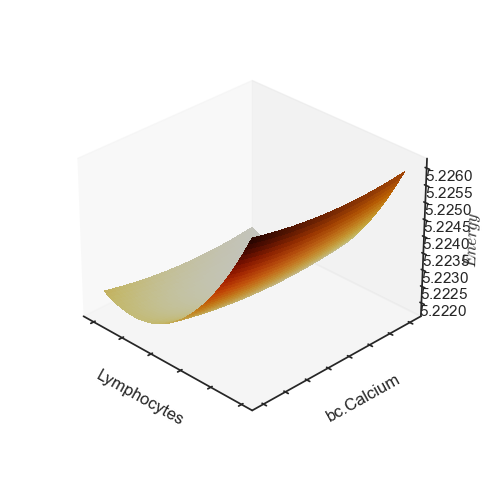

In [410]:
# surface plot for 2d objective function
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from matplotlib import cbook, cm

# sample input range uniformly at 0.1 increments
z = E2d
# create a mesh from the axis
x, y = np.meshgrid(feature_i_grid, feature_j_grid)

# create a surface plot with the jet color scheme
figure = plt.figure()
axis = figure.add_subplot(projection='3d', computed_zorder=False)

ls = LightSource(azdeg=0, altdeg=45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.YlOrBr, vert_exag=0.1, 
               blend_mode='soft')
axis.plot_surface(x, y, z,  #lw=0.5, rstride=50, cstride=50, 
                  # alpha=0.2, 
                  edgecolor='none',
                  facecolors=rgb,
                  antialiased=False,
                 zorder=-1000)
# axis.contourf(x, y, results, zdir='z', offset=0, cmap='coolwarm')
axis.set(xlabel=variable_map[feature_i_name], 
         ylabel=variable_map[feature_j_name], 
         zlabel=r'$Energy$', 
         xticklabels=[], yticklabels=[],
         # zticklabels=[]
        )
axis.xaxis.label.set_size(12)
axis.yaxis.label.set_size(12)
axis.zaxis.label.set_size(12)

axis.grid(False)
axis.view_init(30, -45)
axis.set_box_aspect(aspect=None, zoom=0.8)

# show the plot
plt.savefig(f'{EXP}_{feature_i_name}_{feature_j_name}_3d_surface_sample0.pdf', bbox_inches='tight');

plt.show()


In [411]:


from bokeh.palettes import Sunset8
from bokeh.plotting import figure, show

# Data to contour is the sum of two Gaussian functions.
x, y = np.meshgrid(feature_i_grid, feature_j_grid)
z = E2d

p = figure(width=450, height=400, x_range=(feature_i_grid.min().item(), feature_i_grid.max().item()), 
           y_range=(feature_j_grid.min().item(), feature_j_grid.max().item()),
          output_backend="svg")

levels = np.linspace(E2d.min(), E2d.max(), 10)
contour_renderer = p.contour(x, y, z, levels, fill_color=Sunset8, line_color="black")

p.line(xi_given_xj_F, feature_j_grid, line_width=4, line_color="navy",
       legend_label="x(y)")
p.line(feature_i_grid, xj_given_xi_F, line_width=4, line_color="red",
       legend_label="y(x)")

p.yaxis.axis_label = f"y: {variable_map[feature_j_name]}"
p.xaxis.axis_label = f"x: {variable_map[feature_i_name]}"

p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"

p.xaxis.major_label_text_font_size = "12pt"
p.yaxis.major_label_text_font_size = "12pt"

colorbar = contour_renderer.construct_color_bar()
p.add_layout(colorbar, "right")

show(p)


In [412]:

from bokeh.models import (LinearAxis, Range1d)
from bokeh.palettes import Sunset6
from bokeh.plotting import figure, show

x = feature_i_grid
y = xj_given_xi
y2 = Ej_given_xi

blue, red = Sunset6[2], Sunset6[5]

p = figure(x_range=(feature_i_grid[0].item()-0.1, feature_i_grid[-1].item()), 
           y_range=(xj_given_xi.min().item(), xj_given_xi.max().item()),
          output_backend="svg")


p.line(x, y, line_width=4, line_color="green")


p.xaxis.axis_label = variable_map[feature_i_name]
p.yaxis.axis_label = variable_map[feature_j_name]
p.yaxis.axis_label_text_color = "green"


p.extra_x_ranges['foo'] = Range1d(feature_i_grid[0].item() -0.1, feature_i_grid[-1].item())
p.extra_y_ranges['foo'] = Range1d(Ej_given_xi.min().item(), Ej_given_xi.max().item()+0.01)



p.line(x, y2, 
       line_width=4, line_color="red",
       line_dash="dashed",
        x_range_name="foo",
        y_range_name="foo",
)

ax2 = LinearAxis(
    axis_label="Energy",
    x_range_name="foo",
    y_range_name="foo",
    
)
ax2.axis_label_text_color = "red"

p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"
ax2.axis_label_text_font_size = "14pt"

p.xaxis.major_label_text_font_size = "12pt"
p.yaxis.major_label_text_font_size = "12pt"
ax2.major_label_text_font_size = "12pt"


p.add_layout(ax2, 'right')

show(p)

### Load ICNN Inference from Disk (one-time)

In [ ]:
vars_n300

In [ ]:
all_models_X_test_imp_df = {}
prob_models_X_test_std_df = {}
prob_models_X_var_stats_df = []
all_models_X_test_se = []
all_models_features_stats_df = []
all_models_stats_df = []
PERCENTILES = (95, 90, 80, 70, 60, 50, 25, 10)

for model_name in list(EXP_DIR.keys()) + list(sklearn_imputers.keys()):
    x_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_imp.csv'
    s_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_std.csv'
    if os.path.isfile(x_file):
        X_test_imp_ = pd.read_csv(x_file, index_col=[0])
        all_models_X_test_imp_df[model_name] = X_test_imp_

        # Squared-Errors (per instance)
        X_test_se_ = (X_test_imp_ - np.array(obs_val_test))**2
        X_test_se_ = X_test_se_.where(prediction_mask.astype(bool), other=np.nan)
        X_test_se_ = pd.melt(X_test_se_, value_vars=list(obs_val.columns), value_name='SE')
        X_test_se_ = X_test_se_[X_test_se_.SE.notnull()]
        X_test_se_['Imputer'] = model_name
        all_models_X_test_se.append(X_test_se_)


    if os.path.isfile(s_file):
        X_test_std_ = pd.read_csv(s_file, index_col=[0])
        prob_models_X_test_std_df[model_name] = X_test_std_
        
        X_test_var_ = np.where(prediction_mask.astype(bool), X_test_std_ ** 2, np.nan)
        SE_ = (all_models_X_test_imp_df[model_name] - np.array(obs_val_test)) ** 2
        SE_ = np.where(prediction_mask.astype(bool), SE_, np.nan)
        se_data_ = defaultdict(list)
        for i in range(SE_.shape[1]):
            se_data_['SE'].extend(np.array(SE_[:, i][prediction_mask[:, i].astype(bool)]).tolist())
            se_data_[r'$\hat{\sigma}^2$'].extend(np.array(X_test_var_[:, i][prediction_mask[:, i].astype(bool)]).tolist())
            se_data_['Feature'].extend([obs_val.columns[i]] * int(prediction_mask[:, i].sum()))
        se_df_ = pd.DataFrame(se_data_)
        se_df_['Imputer'] = model_name
        
        prob_models_X_var_stats_df.append(se_df_)

    if model_name not in all_models_X_test_imp_df:
        continue

    # R2/MSE (per feature)
    X_test_imp_ = jnp.array(all_models_X_test_imp_df[model_name])
    features_r2_ = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp_.T, prediction_mask.T)
    se_ = (np.array(all_models_X_test_imp_df[model_name]) - np.array(obs_val_test)) ** 2
    mse_ = np.nanmean(se_, axis=0, where=prediction_mask.astype(bool))
    features_stats_df_ = pd.DataFrame({r'$R^2$': np.array(features_r2_), 
                                       'MSE': mse_,
                                       'Feature': all_models_X_test_imp_df[model_name].columns,
                                       'Imputer': [model_name] * len(mse_)})

    # r_spearman(SE, sigma2) (per feature)
    if model_name in prob_models_X_test_std_df:
        X_test_var_ = np.where(prediction_mask.astype(bool), prob_models_X_test_std_df[model_name] ** 2, np.nan)
        features_stats_df_[r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$'] = [spearmanr(se_i[mi], sigma2_i[mi]).statistic
                                                 for se_i, sigma2_i, mi in zip(se_.T, X_test_var_.T, prediction_mask.astype(bool).T)]
        features_stats_df_[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(se_i[mi], sigma2_i[mi]).statistic if mi.sum() > 2 else float('nan')
                                                 for se_i, sigma2_i, mi in zip(se_.T, X_test_var_.T, prediction_mask.astype(bool).T) ]

        features_stats_df_[r'$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(np.log(se_i[mi]), np.log(sigma2_i[mi])).statistic if mi.sum() > 2 else float('nan')
                                         for se_i, sigma2_i, mi in zip(se_.T, X_test_var_.T, prediction_mask.astype(bool).T) ]

        # After Transpose, shape: (N_percentiles, n_features)
        features_percentiles = np.vstack([np.percentile(sigma2_i[mi], PERCENTILES)  for (sigma2_i, mi) in zip(X_test_var_.T, prediction_mask.astype(bool).T)]).T

        for percent, percentile in zip(PERCENTILES, features_percentiles):
            prediction_mask_p = np.vstack([mi * (sigma2_i <= p_i) for 
                                           (p_i, sigma2_i, mi) in zip(percentile, X_test_var_.T, prediction_mask.astype(bool).T)]).T
            features_stats_df_[rf'$R^2@P{percent}$'] = np.array(eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp_.T, prediction_mask_p.T)).squeeze()
            features_stats_df_[f'MSE@P{percent}'] = np.nanmean(se_, axis=0, where=prediction_mask_p).squeeze()

        
        
        

    all_models_features_stats_df.append(features_stats_df_)

    # R2/MSE (per model)
    features_stats_300_df = features_stats_df_[features_stats_df_.Feature.isin(vars_n300)]
    weighted_avg_R2 = np.average(features_stats_300_df[r'$R^2$'], 
                                 weights=features_stats_300_df['Feature'].map(n_test_censored))
    
    model_stats_df_ = pd.DataFrame({'Imputer': [model_name],
                                    'MSE': [np.nanmean(se_, where=prediction_mask.astype(bool))],
                                    r'$R^2$': [ProbICNNImputerTrainer.r_squared(obs_val_test, X_test_imp_, prediction_mask).item()],
                                    r'MICRO-AVG($R^2$)': [ProbICNNImputerTrainer.r_squared_micro_average(obs_val_test, X_test_imp_, prediction_mask).item()],
                                    r'MACRO-AVG($R^2$)*': [features_stats_300_df[r'$R^2$'].mean()]})

    # corr(SE, sigma2) (per model)
    if model_name in prob_models_X_test_std_df:
        X_test_var_ = np.where(prediction_mask.astype(bool), prob_models_X_test_std_df[model_name] ** 2, np.nan).flatten()
        m_ = prediction_mask.astype(bool).flatten()
        model_stats_df_[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(se_.flatten()[m_], X_test_var_[m_]).statistic]
        model_stats_df_[r'$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(np.log(se_.flatten()[m_]), np.log(X_test_var_[m_])).statistic]

        model_stats_df_[r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$'] = [spearmanr(se_.flatten()[m_], X_test_var_[m_]).statistic]
    all_models_stats_df.append(model_stats_df_)
    
all_models_X_test_se = pd.concat(all_models_X_test_se)
prob_models_X_var_stats_df = pd.concat(prob_models_X_var_stats_df)
all_models_features_stats_df = pd.concat(all_models_features_stats_df)
all_models_stats_df = pd.concat(all_models_stats_df)

prob_models_X_var_stats_df['LN'] = prob_models_X_var_stats_df['SE'] / prob_models_X_var_stats_df[r'$\hat{\sigma}^2$'] + np.log(prob_models_X_var_stats_df[r'$\hat{\sigma}^2$'])

In [353]:
EXP = 'ICNN_NLN'

spearman_corr = all_models_X_test_imp_df[EXP].corr(method='spearman')

In [354]:
important_corr = []
for i, f1 in enumerate(spearman_corr.columns):
    for f2 in spearman_corr.columns[i+1:]:
        c = spearman_corr.loc[f1, f2]
        if abs(c) > 0.6:
            important_corr.append((f1, f2, c))
important_corr_df = pd.DataFrame(important_corr, columns=['Feature_A', 'Feature_B', 'Spearman'])
important_corr_df.to_csv(f'{EXP}_spearman_corr.csv')

In [59]:
# all_models_features_stats_df
features_LN = prob_models_X_var_stats_df.groupby(['Imputer', 'Feature'])['LN'].mean()
all_models_features_stats_df = all_models_features_stats_df.set_index(['Imputer', 'Feature'])
all_models_features_stats_df.loc[features_LN.index, 'LN'] = features_LN
all_models_features_stats_df = all_models_features_stats_df.reset_index()
all_models_features_stats_df

,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,...,MSE@P70,$R^2@P60$,MSE@P60,$R^2@P50$,MSE@P50,$R^2@P25$,MSE@P25,$R^2@P10$,MSE@P10,LN
0,ICNN_LN,blood_chemistry.albumin,-16.566409,0.300528,0.091599,0.092006,0.068574,-16.052827,0.296367,-15.797195,...,0.276832,-14.655160,0.275311,-13.905699,0.253945,-15.429407,0.237115,-25.363047,0.315653,0.271865
1,ICNN_LN,blood_chemistry.aniongap,-1.127125,0.042875,0.196552,0.334388,0.189528,-0.836212,0.037233,-0.730507,...,0.028258,-0.483467,0.027951,-0.479119,0.027326,-0.532119,0.026209,-0.527224,0.027201,-2.244770
2,ICNN_LN,blood_chemistry.bicarbonate,-1.617774,0.035445,0.275070,0.348982,0.293107,-1.128774,0.028479,-0.776244,...,0.017567,-0.412419,0.017276,-0.426036,0.016835,-0.403342,0.015159,-0.279126,0.012869,-2.638046
3,ICNN_LN,blood_chemistry.bun,-0.426345,0.060286,0.229181,0.337896,0.219976,-0.226836,0.052031,-0.150894,...,0.044348,-0.072008,0.042406,-0.095584,0.040899,-0.116745,0.039349,-0.254159,0.040286,-1.513641
4,ICNN_LN,blood_chemistry.calcium,-2.590642,0.014531,0.137374,0.316083,0.194179,-1.991589,0.012180,-1.619286,...,0.009093,-1.225008,0.008962,-1.177847,0.008865,-1.223703,0.009074,-1.181541,0.009263,-3.369361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,iter_imputer,vital.sbp,0.452593,0.007647,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1396,iter_imputer,vital.sbp_ni,0.820376,0.002518,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1397,iter_imputer,vital.spo2,-0.972564,0.001281,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1398,iter_imputer,vital.temperature,-0.918125,0.000421,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
models_LN = prob_models_X_var_stats_df.groupby(['Imputer'])['LN'].mean()
all_models_stats_df = all_models_stats_df.set_index('Imputer')
all_models_stats_df.loc[models_LN.index, 'LN'] = models_LN
all_models_stats_df = all_models_stats_df.reset_index()
all_models_stats_df

,Imputer,MSE,$R^2$,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*,"$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(SE, \hat{\sigma}^2)$",LN
0,ICNN_LN,0.187529,-0.550462,-0.868452,-49.860947,0.384279,0.566011,0.584695,-2.653340
1,ICNN_NLN,0.053932,0.554094,0.462641,-2.840913,0.297608,0.508525,0.535573,-2.983635
2,ICNN_KL,0.067870,0.438862,0.323777,-8.690414,0.014612,0.139310,0.127961,51.991841
3,ICNN_NKL,0.076823,0.364835,0.234567,-5.458273,0.006390,0.062175,0.071820,34.843839
4,ICNN_KLR,0.156106,-0.290663,-0.555369,-38.214189,0.313366,0.573460,0.599762,-2.690029
5,ICNN_NKLR,0.056590,0.532122,0.436163,-3.240241,0.304226,0.534544,0.579332,-2.894684
6,ICNN_JSD,0.071545,0.408476,0.287158,-36.209339,0.051561,0.215165,0.212805,15.454569
7,ICNN_NJSD,0.071596,0.408053,0.286649,-8.508194,0.041852,0.130890,0.152721,13.025380
8,ICNN_MSE,0.061777,0.489232,0.384477,-4.550422,NaN,NaN,NaN,NaN
9,ICNN_NMSE,0.077563,0.358723,0.227201,-0.866756,NaN,NaN,NaN,NaN


In [61]:
prob_models_X_var_stats_df.groupby(['Imputer'])['LN'].mean()

Imputer
ICNN_JSD     15.454569
ICNN_KL      51.991841
ICNN_KLR     -2.690029
ICNN_LN      -2.653340
ICNN_NJSD    13.025380
ICNN_NKL     34.843839
ICNN_NKLR    -2.894684
ICNN_NLN     -2.983635
Name: LN, dtype: float64

In [62]:
all_models_features_stats_df.Imputer.unique()

array(['ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL', 'ICNN_KLR',
       'ICNN_NKLR', 'ICNN_JSD', 'ICNN_NJSD', 'ICNN_MSE', 'ICNN_NMSE',
       'zero_imputer', 'mean_imputer', 'knn_imputer', 'iter_imputer'],
      dtype=object)

In [63]:
p_abundance = obs_mask.mean(axis=0)
for name, model_df in all_models_features_stats_df.groupby('Imputer'):
    df = model_df[model_df.Feature.isin(vars_n300)]
    stat = spearmanr(df[r'$R^2$'], df.Feature.map(p_abundance)).statistic
    loc = all_models_stats_df.Imputer == name
    all_models_stats_df.loc[loc, r'$r_\text{Spearman}(R^2, \text{abundance})$'] = stat
    

In [64]:
all_models_stats_df

,Imputer,MSE,$R^2$,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*,"$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(SE, \hat{\sigma}^2)$",LN,"$r_\text{Spearman}(R^2, \text{abundance})$"
0,ICNN_LN,0.187529,-0.550462,-0.868452,-49.860947,0.384279,0.566011,0.584695,-2.653340,0.648649
1,ICNN_NLN,0.053932,0.554094,0.462641,-2.840913,0.297608,0.508525,0.535573,-2.983635,0.466957
2,ICNN_KL,0.067870,0.438862,0.323777,-8.690414,0.014612,0.139310,0.127961,51.991841,0.434068
3,ICNN_NKL,0.076823,0.364835,0.234567,-5.458273,0.006390,0.062175,0.071820,34.843839,0.108602
4,ICNN_KLR,0.156106,-0.290663,-0.555369,-38.214189,0.313366,0.573460,0.599762,-2.690029,0.643620
5,ICNN_NKLR,0.056590,0.532122,0.436163,-3.240241,0.304226,0.534544,0.579332,-2.894684,0.411082
6,ICNN_JSD,0.071545,0.408476,0.287158,-36.209339,0.051561,0.215165,0.212805,15.454569,0.364094
7,ICNN_NJSD,0.071596,0.408053,0.286649,-8.508194,0.041852,0.130890,0.152721,13.025380,0.100827
8,ICNN_MSE,0.061777,0.489232,0.384477,-4.550422,NaN,NaN,NaN,NaN,0.516753
9,ICNN_NMSE,0.077563,0.358723,0.227201,-0.866756,NaN,NaN,NaN,NaN,0.085863


In [65]:
all_models_features_stats_df

,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,...,MSE@P70,$R^2@P60$,MSE@P60,$R^2@P50$,MSE@P50,$R^2@P25$,MSE@P25,$R^2@P10$,MSE@P10,LN
0,ICNN_LN,blood_chemistry.albumin,-16.566409,0.300528,0.091599,0.092006,0.068574,-16.052827,0.296367,-15.797195,...,0.276832,-14.655160,0.275311,-13.905699,0.253945,-15.429407,0.237115,-25.363047,0.315653,0.271865
1,ICNN_LN,blood_chemistry.aniongap,-1.127125,0.042875,0.196552,0.334388,0.189528,-0.836212,0.037233,-0.730507,...,0.028258,-0.483467,0.027951,-0.479119,0.027326,-0.532119,0.026209,-0.527224,0.027201,-2.244770
2,ICNN_LN,blood_chemistry.bicarbonate,-1.617774,0.035445,0.275070,0.348982,0.293107,-1.128774,0.028479,-0.776244,...,0.017567,-0.412419,0.017276,-0.426036,0.016835,-0.403342,0.015159,-0.279126,0.012869,-2.638046
3,ICNN_LN,blood_chemistry.bun,-0.426345,0.060286,0.229181,0.337896,0.219976,-0.226836,0.052031,-0.150894,...,0.044348,-0.072008,0.042406,-0.095584,0.040899,-0.116745,0.039349,-0.254159,0.040286,-1.513641
4,ICNN_LN,blood_chemistry.calcium,-2.590642,0.014531,0.137374,0.316083,0.194179,-1.991589,0.012180,-1.619286,...,0.009093,-1.225008,0.008962,-1.177847,0.008865,-1.223703,0.009074,-1.181541,0.009263,-3.369361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,iter_imputer,vital.sbp,0.452593,0.007647,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1396,iter_imputer,vital.sbp_ni,0.820376,0.002518,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1397,iter_imputer,vital.spo2,-0.972564,0.001281,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1398,iter_imputer,vital.temperature,-0.918125,0.000421,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
r_classes = [r'$r > 0.3$', r'$r \in [0.1, 0.3]$', r'$r \in [-0.1, 0.1]$', r'$r \leq -0.1$']
R_classes = [r'$R^2 > 0.25$', r'$R^2 \in (0.1, 0.25]$', r'$R^2 \in [-0.1, 0.1]$', r'$R^2 \in (-1, -0.1]$',  r'$R^2 \in (-9, -1]$', r'$R^2 < -9$']
def classify_r(r):
    if r > 0.3:
        return r_classes[0]
    elif r > 0.1:
        return r_classes[1]
    elif r >= -0.1:
        return r_classes[2]
    elif r < -0.1:
        return r_classes[3]
    else:
        return 'NA'

def classify_R(R):
    if R > 0.25:
        return R_classes[0]
    elif R > 0.1:
        return R_classes[1]
    elif R >= -0.1:
        return R_classes[2]
    elif R >= -1:
        return R_classes[3] 
    elif R >= -9:
        return R_classes[4]
    elif R < -9:
        return R_classes[5]
    else:
        return 'NA'

all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'] = all_models_features_stats_df[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'].map(classify_r)
all_models_features_stats_df[r'$r_\text{log}(SE, \hat{\sigma}^2)$ bin'] = all_models_features_stats_df[r'$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$'].map(classify_r)

all_models_features_stats_df[r'$R^2$ bin'] = all_models_features_stats_df[r'$R^2$'].map(classify_R)


In [67]:
for p in PERCENTILES:
    all_models_features_stats_df[rf'$R^2@P{p}$ bin'] = all_models_features_stats_df[rf'$R^2@P{p}$'].map(classify_R)


In [68]:
all_models_features_stats_df

,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,...,"$r_\text{log}(SE, \hat{\sigma}^2)$ bin",$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin
0,ICNN_LN,blood_chemistry.albumin,-16.566409,0.300528,0.091599,0.092006,0.068574,-16.052827,0.296367,-15.797195,...,"$r \in [-0.1, 0.1]$",$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$
1,ICNN_LN,blood_chemistry.aniongap,-1.127125,0.042875,0.196552,0.334388,0.189528,-0.836212,0.037233,-0.730507,...,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
2,ICNN_LN,blood_chemistry.bicarbonate,-1.617774,0.035445,0.275070,0.348982,0.293107,-1.128774,0.028479,-0.776244,...,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
3,ICNN_LN,blood_chemistry.bun,-0.426345,0.060286,0.229181,0.337896,0.219976,-0.226836,0.052031,-0.150894,...,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
4,ICNN_LN,blood_chemistry.calcium,-2.590642,0.014531,0.137374,0.316083,0.194179,-1.991589,0.012180,-1.619286,...,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,iter_imputer,vital.sbp,0.452593,0.007647,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,$R^2 > 0.25$,NA,NA,NA,NA,NA,NA,NA,NA
1396,iter_imputer,vital.sbp_ni,0.820376,0.002518,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,$R^2 > 0.25$,NA,NA,NA,NA,NA,NA,NA,NA
1397,iter_imputer,vital.spo2,-0.972564,0.001281,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,"$R^2 \in (-1, -0.1]$",NA,NA,NA,NA,NA,NA,NA,NA
1398,iter_imputer,vital.temperature,-0.918125,0.000421,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,"$R^2 \in (-1, -0.1]$",NA,NA,NA,NA,NA,NA,NA,NA


In [69]:
len(vars_n300)

73

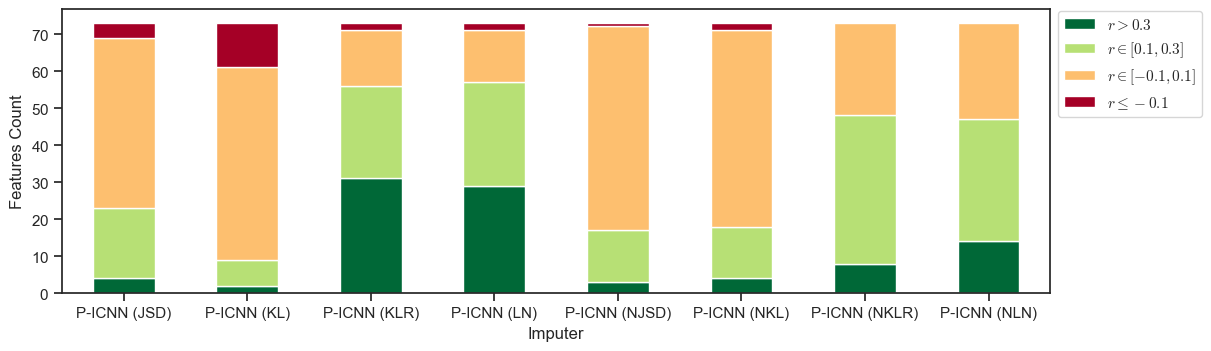

In [72]:
prob_models_features_stats_df = all_models_features_stats_df[all_models_features_stats_df[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'].notnull()]
prob_models_features_stats_df = prob_models_features_stats_df[prob_models_features_stats_df.Feature.isin(vars_n300)]

prob_models_features_stats_df['Imputer'] = prob_models_features_stats_df['Imputer'].map(ICNN_RENAMES)

r_bins = prob_models_features_stats_df.groupby(['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin'])['Feature'].count().reset_index()
r_bins.columns = ['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin', 'Count']
r_bins = r_bins.pivot_table(index="Imputer", values='Count', columns=r'$r(SE, \hat{\sigma}^2)$ bin')


ax = r_bins.plot(y=r_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 2., fig_height_in * 2)
ax.get_figure().savefig(f"{RESULTS_DIR}/prob_icnn_r_bins.pdf")

In [77]:
table_ablation0 = all_models_stats_df.copy()

table_ablation0['Imputer'] = all_models_stats_df['Imputer'].map(ICNN_RENAMES)
ablation_models = [m for m in table_ablation0.Imputer.unique() if m == m and  m.startswith('P-ICNN')]

table_ablation0 = table_ablation0.set_index('Imputer').loc[ablation_models,  ['MSE', r'MICRO-AVG($R^2$)',  r'MACRO-AVG($R^2$)*', 'LN', r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] ].transpose()
table_ablation0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table_ablation0.columns))
table_ablation0.columns = list(map(lambda c: c.replace("_", "\\_"), table_ablation0.columns))
table_ablation0.columns.name = 'Imputer'
# table_ablation0 = table_ablation0.sort_values('MSE', ascending=False, axis=1)
table_ablation0 = table_ablation0.transpose()
table_ablation0

,MSE,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*,LN,"$r_\text{Pearson}(SE, \hat{\sigma}^2)$"
Imputer,,,,,
\texttt{P-ICNN (LN)},0.187529,-0.868452,-49.860947,-2.653340,0.384279
\texttt{P-ICNN (NLN)},0.053932,0.462641,-2.840913,-2.983635,0.297608
\texttt{P-ICNN (KL)},0.067870,0.323777,-8.690414,51.991841,0.014612
\texttt{P-ICNN (NKL)},0.076823,0.234567,-5.458273,34.843839,0.006390
\texttt{P-ICNN (KLR)},0.156106,-0.555369,-38.214189,-2.690029,0.313366
\texttt{P-ICNN (NKLR)},0.056590,0.436163,-3.240241,-2.894684,0.304226
\texttt{P-ICNN (JSD)},0.071545,0.287158,-36.209339,15.454569,0.051561
\texttt{P-ICNN (NJSD)},0.071596,0.286649,-8.508194,13.025380,0.041852


In [109]:
table_stl_ablation0 = (table_ablation0.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.05, high=0.110,  vmin=0.05, vmax=0.110, subset= pd.IndexSlice[:, ['MSE']])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table_stl_ablation0

,MSE,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*,LN,"$r_\text{Pearson}(SE, \hat{\sigma}^2)$"
Imputer,,,,,
\texttt{P-ICNN (LN)},0.188,-0.868,-49.861,-2.653,0.384
\texttt{P-ICNN (NLN)},0.054,0.463,-2.841,-2.984,0.298
\texttt{P-ICNN (KL)},0.068,0.324,-8.690,51.992,0.015
\texttt{P-ICNN (NKL)},0.077,0.235,-5.458,34.844,0.006
\texttt{P-ICNN (KLR)},0.156,-0.555,-38.214,-2.690,0.313
\texttt{P-ICNN (NKLR)},0.057,0.436,-3.240,-2.895,0.304
\texttt{P-ICNN (JSD)},0.072,0.287,-36.209,15.455,0.052
\texttt{P-ICNN (NJSD)},0.072,0.287,-8.508,13.025,0.042


In [110]:
table_ltx_ablation0 = (table_stl_ablation0.to_latex(caption=r"Ablation study on the effect of the probabilistic loss function choice on the performance of "
                                                    r"\texttt{P-ICNN} models. The estimations are made on the validation split."
                                                    r"For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, "
                                                    r"of which some have $-\infty$ values. "
                                                    r"LN is the lognormal loss (not necessarily used in training)."
                                                    r" $r_\text{Pearson}(SE, \hat{\sigma}^2)$ is the correlation between the prediction \gls*{se} and the predicted variance (the higher the better).",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table_ltx_ablation0)

\begin{table}
\centering
\caption{Ablation study on the effect of the probabilistic loss function choice on the performance of \texttt{P-ICNN} models. The estimations are made on the validation split.For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, of which some have $-\infty$ values. LN is the lognormal loss (not necessarily used in training). $r_\text{Pearson}(SE, \hat{\sigma}^2)$ is the correlation between the prediction \gls*{se} and the predicted variance (the higher the better).}
\begin{tabular}{lrrrrr}
\hline
 & MSE & MICRO-AVG($R^2$) & MACRO-AVG($R^2$)* & LN & $r_\text{Pearson}(SE, \hat{\sigma}^2)$ \\
Imputer &  &  &  &  &  \\
\hline
\texttt{P-ICNN (LN)} & {\cellcolor[HTML]{A50026}} \color[HTML]{F1F1F1} 0.188 & -0.868 & -49.861 & -2.653 & 0.384 \\
\texttt{P-ICNN (NLN)} & {\cellcolor[HTML]{199750}} \color[HTML]{F1F1F1} 0.054 & 0.463 & -2.841 & -2.984 & 0.298 \\
\texttt{P-ICNN (KL)} & {\cellcolor[HTML]{A5D86A}} \color[HTML]{000000}

In [102]:
table_ablation1 = all_models_stats_df.copy()

table_ablation1['Imputer'] = all_models_stats_df['Imputer'].map(ICNN_RENAMES)
ablation_models = [m for m in table_ablation1.Imputer.unique() if m == m and  m.startswith('S-ICNN')]

table_ablation1 = table_ablation1.set_index('Imputer').loc[ablation_models,  ['MSE', r'MICRO-AVG($R^2$)', r'MACRO-AVG($R^2$)*'] ].transpose()
table_ablation1.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table_ablation1.columns))
table_ablation1.columns = list(map(lambda c: c.replace("_", "\\_"), table_ablation1.columns))
table_ablation1.columns.name = 'Imputer'
table_ablation1 = table_ablation1.sort_values('MSE', ascending=False, axis=1)
table_ablation1 = table_ablation1.transpose()
# table_ablation1.columns = table_ablation1.columns.droplevel(0)
table_ablation1

,MSE,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*
Imputer,,,
\texttt{S-ICNN (NMSE)},0.077563,0.227201,-0.866756
\texttt{S-ICNN (MSE)},0.061777,0.384477,-4.550422


In [107]:
table_stl_ablation1 = (table_ablation1.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              .background_gradient(cmap='RdYlGn_r', axis=0,  low=0.05, high=0.110,  vmin=0.05, vmax=0.110, subset= pd.IndexSlice[:, ['MSE']])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table_stl_ablation1

,MSE,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*
Imputer,,,
\texttt{S-ICNN (NMSE)},0.078,0.227,-0.867
\texttt{S-ICNN (MSE)},0.062,0.384,-4.550


In [108]:
table_ltx_ablation1 = (table_stl_ablation1.to_latex(caption=r"Ablation study on the effect of the loss function choice on the performance of \texttt{S-ICNN} models. "
                                                    r"First row: \gls*{mse} loss across all features on the test split. Second and third rows list the micro and macro average of $R^2$ "
                                                    r"(higher is better), respectively. For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, "
                                                    r"of which some have $-\infty$ values.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table_ltx_ablation1)

\begin{table}
\centering
\caption{Ablation study on the effect of the loss function choice on the performance of \texttt{S-ICNN} models. First row: \gls*{mse} loss across all features on the test split. Second and third rows list the micro and macro average of $R^2$ (higher is better), respectively. For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, of which some have $-\infty$ values.}
\begin{tabular}{lrrr}
\hline
 & MSE & MICRO-AVG($R^2$) & MACRO-AVG($R^2$)* \\
Imputer &  &  &  \\
\hline
\texttt{S-ICNN (NMSE)} & {\cellcolor[HTML]{E8F59F}} \color[HTML]{000000} 0.078 & 0.227 & -0.867 \\
\texttt{S-ICNN (MSE)} & {\cellcolor[HTML]{6EC064}} \color[HTML]{000000} 0.062 & 0.384 & -4.550 \\
\hline
\end{tabular}
\end{table}



In [111]:
S_ICNN = ('ICNN_NMSE', 'ICNN_MSE')
P_ICNN = ('ICNN_NKLR', 'ICNN_NLN')
# P_ICNN_RENAME = {'ICNN_NKL': 'ICNN (KL)', 
#                  'ICNN_NLN': 'ICNN (LN)'}

final_models_X_test_se = all_models_X_test_se[((all_models_X_test_se.Imputer.str.count('ICNN') == 0) | 
                                               (all_models_X_test_se.Imputer.isin(S_ICNN + P_ICNN)))]

final_models_features_stats_df = all_models_features_stats_df[((all_models_features_stats_df.Imputer.str.count('ICNN') == 0) |
                                                               (all_models_features_stats_df.Imputer.isin(S_ICNN + P_ICNN)))]
final_models_stats_df = all_models_stats_df[((all_models_stats_df.Imputer.str.count('ICNN') == 0) |
                                             (all_models_stats_df.Imputer.isin(S_ICNN + P_ICNN)))]

for df in (final_models_X_test_se, final_models_features_stats_df, final_models_stats_df):
    df['Imputer'] = df['Imputer'].replace(ICNN_RENAMES)   


/tmp/ipykernel_179179/4041969994.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Imputer'] = df['Imputer'].replace(ICNN_RENAMES)


In [112]:
final_models_stats_df.Imputer.unique()

array(['P-ICNN (NLN)', 'P-ICNN (NKLR)', 'S-ICNN (MSE)', 'S-ICNN (NMSE)',
       'zero_imputer', 'mean_imputer', 'knn_imputer', 'iter_imputer'],
      dtype=object)

## Metrics of Sklearn Models

In [113]:
# FIRST TIME - BEGIN 
# sklearn_imputed_X = {k: v.transform(np.where(art_mask_test, obs_val_test, np.nan)) for k, v in sklearn_trained_imputers.items()} 
# for sklearn_name, imputed_X_ in sklearn_imputed_X.items():
#     X_test_imp_df = pd.DataFrame(imputed_X_, columns=obs_val.columns)    
#     X_test_imp_df.to_csv(f'{RESULTS_DIR}/{sklearn_name}_pred_X_test_imp.csv')
# FIRST TIME - END 

In [114]:
all_models_X_test_se.Imputer.unique()

array(['ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL', 'ICNN_KLR',
       'ICNN_NKLR', 'ICNN_JSD', 'ICNN_NJSD', 'ICNN_MSE', 'ICNN_NMSE',
       'zero_imputer', 'mean_imputer', 'knn_imputer', 'iter_imputer'],
      dtype=object)

In [115]:
final_models_X_test_se['group'] = final_models_X_test_se.variable.str.split('.').map(lambda x: x[0])
final_models_X_test_se['Feature'] = final_models_X_test_se.variable.map(variable_map)

/tmp/ipykernel_179179/4136769991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_models_X_test_se['group'] = final_models_X_test_se.variable.str.split('.').map(lambda x: x[0])
/tmp/ipykernel_179179/4136769991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_models_X_test_se['Feature'] = final_models_X_test_se.variable.map(variable_map)


In [116]:
groups = final_models_X_test_se['group'].unique().tolist()
groups

['blood_chemistry',
 'blood_diff',
 'blood_gas',
 'cardiac_marker',
 'cbc',
 'coagulation',
 'enzymes',
 'icp',
 'inflammation',
 'renal_aki',
 'renal_creat',
 'renal_out',
 'sofa',
 'vital',
 'weight']

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


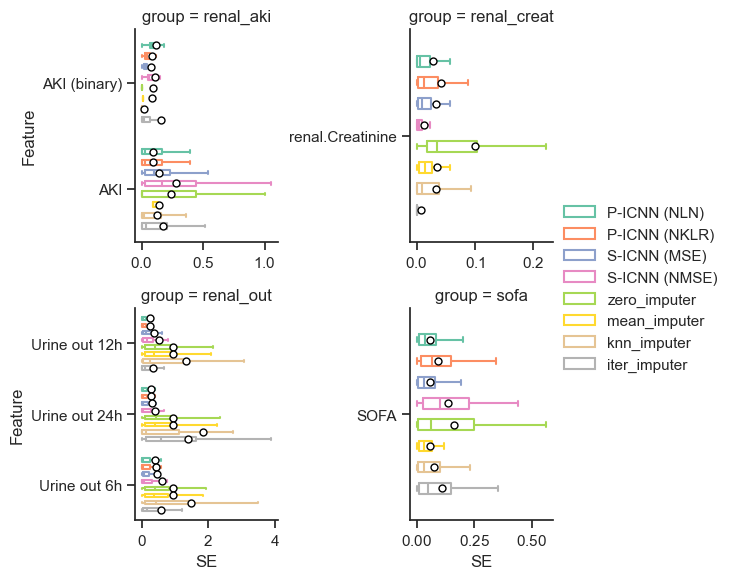

In [120]:
# enzymes (except Amylase, Bilirubin indirect, CK-CPK)
# renal_creat
# renal_aki
# renal_out
# sofa

X_test_se_df_selection = final_models_X_test_se[final_models_X_test_se.group.isin(['renal_out', 'renal_creat', 'renal_aki', 'sofa'])]

grid = sns.FacetGrid(data=X_test_se_df_selection, col="group", sharex=False, sharey=False, col_wrap=2,  )

grid.map_dataframe(sns.boxplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
                   showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'5'},
                    # line_kws=dict(linewidth=1.5, color="#cde"),
                    showfliers=False,
                    fill=False,
                     gap=0.5)

# grid.map_dataframe(sns.boxenplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
#                     # line_kws=dict(linewidth=1.5, color="#cde"),
#                     showfliers=False,
#                     fill=False,
#                      gap=0.5)

grid.add_legend()
grid.figure.set_size_inches(fig_width_in * 1.3, fig_height_in * 3.5)
grid.savefig(f"{RESULTS_DIR}/X_test_se_df_selection.pdf")

In [121]:

all_models_features_stats_df['abundance'] = all_models_features_stats_df.Feature.map(p_abundance)

all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                              all_models_features_stats_df[r'$R^2$ bin'].isin(R_classes[:2]) &
                             all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[:2]))]


,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,...,$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin,abundance
135,ICNN_NLN,blood_gas.fio2_chartevents,0.425382,0.022148,0.396857,0.376020,0.401129,0.448164,0.021354,0.490292,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.022110
141,ICNN_NLN,blood_gas.pao2fio2ratio,0.362632,0.024220,0.210175,0.161650,0.173983,0.376011,0.023428,0.392264,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,"$R^2 \in [-0.1, 0.1]$",0.022511
149,ICNN_NLN,blood_gas.totalco2,0.365834,0.010889,0.228080,0.374693,0.201060,0.413245,0.009864,0.443627,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,"$R^2 \in (0.1, 0.25]$","$R^2 \in [-0.1, 0.1]$",0.034184
153,ICNN_NLN,cbc.hematocrit,0.421010,0.008246,0.205522,0.306155,0.208169,0.454605,0.007799,0.526089,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.103502
154,ICNN_NLN,cbc.hemoglobin,0.476501,0.007911,0.142645,0.177300,0.121452,0.507155,0.007413,0.524194,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.096569
159,ICNN_NLN,cbc.rbc,0.158481,0.013490,0.161018,0.246869,0.148585,0.199044,0.012716,0.236138,...,"$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$",$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.095661
182,ICNN_NLN,renal_aki.aki_stage_smoothed,0.344889,0.093191,0.545032,0.420887,0.504137,0.391919,0.085995,0.418716,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,"$R^2 \in [-0.1, 0.1]$",$R^2 > 0.25$,0.323320
183,ICNN_NLN,renal_creat.creat,0.191970,0.028084,0.258253,0.256933,0.217224,0.240032,0.025781,0.249618,...,"$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$",$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.041046
184,ICNN_NLN,renal_out.uo_rt_12hr,0.734436,0.250931,0.216300,0.221077,0.191319,0.778356,0.206297,0.797111,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.229034
185,ICNN_NLN,renal_out.uo_rt_24hr,0.710142,0.270389,0.066136,0.114451,0.116473,0.745235,0.234055,0.752675,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.192998


In [122]:

all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                              all_models_features_stats_df[r'$R^2$ bin'].isin(R_classes[:2]) &
                             all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[2:]))]


,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,...,$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin,abundance
125,ICNN_NLN,blood_diff.neutrophils_abs,0.132436,0.041559,-0.007306,0.01017,-0.036897,0.121625,0.041805,0.126306,...,"$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$",0.015558


In [123]:

all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                              # all_models_features_stats_df[r'$R^2$ bin'].isin(R_classes[1:]) &
                             all_models_features_stats_df[r'$r_\text{log}(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[:1]) &
                              (all_models_features_stats_df['LN'] < 0))
]


,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,...,$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin,abundance
135,ICNN_NLN,blood_gas.fio2_chartevents,0.425382,0.022148,0.396857,0.376020,0.401129,0.448164,0.021354,0.490292,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.022110
181,ICNN_NLN,renal_aki.aki_binary,-0.380177,0.118516,0.468694,0.397798,0.323840,-0.401493,0.111381,-0.460042,...,"$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$",0.138943
182,ICNN_NLN,renal_aki.aki_stage_smoothed,0.344889,0.093191,0.545032,0.420887,0.504137,0.391919,0.085995,0.418716,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,"$R^2 \in [-0.1, 0.1]$",$R^2 > 0.25$,0.323320
192,ICNN_NLN,vital.mbp,0.215704,0.011125,0.468802,0.337229,0.339762,0.344234,0.009281,0.407746,...,"$R^2 \in (0.1, 0.25]$",$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.516103


In [65]:
# TODO: For each feature, exclude the points on the upper part of uncertainty, then recompute the metrics again.

In [66]:
final_models_stats_df.columns

In [125]:
table0 = final_models_stats_df[['Imputer', 'MSE', r'MICRO-AVG($R^2$)', r'MACRO-AVG($R^2$)*']].set_index('Imputer').transpose()
table0 = table0[['P-ICNN (NLN)', 'P-ICNN (NKLR)', 'S-ICNN (MSE)', 'S-ICNN (NMSE)', 'zero_imputer', 'mean_imputer', 'knn_imputer', 'iter_imputer']]
# table0.columns = list(table0.columns['P-ICNN', 'S-ICNN', 'zero', 'mean', 'knn', 'iter']
table0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table0.columns))
table0.columns = list(map(lambda c: c.replace("_", "\\_"), table0.columns))
table0.columns.name = 'Imputer'
table0 = table0.transpose().sort_values('MSE', axis=0, ascending=False)
table0

,MSE,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*
Imputer,,,
\texttt{zero\_imputer},0.188635,-0.879470,-4.101035
\texttt{knn\_imputer},0.142751,-0.422312,0.143208
\texttt{mean\_imputer},0.100373,-0.000074,-0.000799
\texttt{iter\_imputer},0.086248,0.140662,-0.229407
\texttt{S-ICNN (NMSE)},0.077563,0.227201,-0.866756
\texttt{S-ICNN (MSE)},0.061777,0.384477,-4.550422
\texttt{P-ICNN (NKLR)},0.056590,0.436163,-3.240241
\texttt{P-ICNN (NLN)},0.053932,0.462641,-2.840913


In [126]:
table0_stl = (table0.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'MICRO-AVG($R^2$)'], :])
              .background_gradient(cmap='RdYlGn_r', axis=0,  low=0.05, high=0.28,  vmin=0.05, vmax=0.19, subset= pd.IndexSlice[:, ['MSE']])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table0_stl

,MSE,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*
Imputer,,,
\texttt{zero\_imputer},0.189,-0.879,-4.101
\texttt{knn\_imputer},0.143,-0.422,0.143
\texttt{mean\_imputer},0.100,-0.000,-0.001
\texttt{iter\_imputer},0.086,0.141,-0.229
\texttt{S-ICNN (NMSE)},0.078,0.227,-0.867
\texttt{S-ICNN (MSE)},0.062,0.384,-4.550
\texttt{P-ICNN (NKLR)},0.057,0.436,-3.240
\texttt{P-ICNN (NLN)},0.054,0.463,-2.841


In [127]:
table0_str = (table0_stl.to_latex(caption=r"Comparison between imputation methods. The estimations are made on the validation split."
                                          r"For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in "
                                          r"the test split are excluded, "
                                          r"of which some have $-\infty$ values.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table0_str)

\begin{table}
\centering
\caption{Comparison between imputation methods. The estimations are made on the validation split.For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, of which some have $-\infty$ values.}
\begin{tabular}{lrrr}
\hline
 & MSE & MICRO-AVG($R^2$) & MACRO-AVG($R^2$)* \\
Imputer &  &  &  \\
\hline
\texttt{zero\_imputer} & {\cellcolor[HTML]{F57748}} \color[HTML]{F1F1F1} 0.189 & -0.879 & -4.101 \\
\texttt{knn\_imputer} & {\cellcolor[HTML]{FFF3AC}} \color[HTML]{000000} 0.143 & -0.422 & 0.143 \\
\texttt{mean\_imputer} & {\cellcolor[HTML]{A9DA6C}} \color[HTML]{000000} 0.100 & -0.000 & -0.001 \\
\texttt{iter\_imputer} & {\cellcolor[HTML]{7AC665}} \color[HTML]{000000} 0.086 & 0.141 & -0.229 \\
\texttt{S-ICNN (NMSE)} & {\cellcolor[HTML]{5AB760}} \color[HTML]{F1F1F1} 0.078 & 0.227 & -0.867 \\
\texttt{S-ICNN (MSE)} & {\cellcolor[HTML]{199750}} \color[HTML]{F1F1F1} 0.062 & 0.384 & -4.550 \\
\texttt{P-ICNN (NKLR)} & {\cellcolor[HTML]{

In [130]:
final_models_filtered_features_stats_df = final_models_features_stats_df[final_models_features_stats_df.Feature.isin(vars_n300)]
R_bins = final_models_filtered_features_stats_df.groupby(['Imputer', r'$R^2$ bin'])['Feature'].count().reset_index()
R_bins.columns = ['Imputer', r'$R^2$ bin', 'Count']
R_bins = R_bins.pivot_table(index="Imputer", values='Count', columns=r'$R^2$ bin')

R_bins = R_bins[R_classes]
R_bins = R_bins.loc[['P-ICNN (NLN)', 'P-ICNN (NKLR)', 'S-ICNN (MSE)', 'S-ICNN (NMSE)', 'zero_imputer', 'mean_imputer', 'knn_imputer', 'iter_imputer'], :]
# R_bins.index = ['P-ICNN', 'S-ICNN', 'zero', 'mean', 'knn', 'iter']

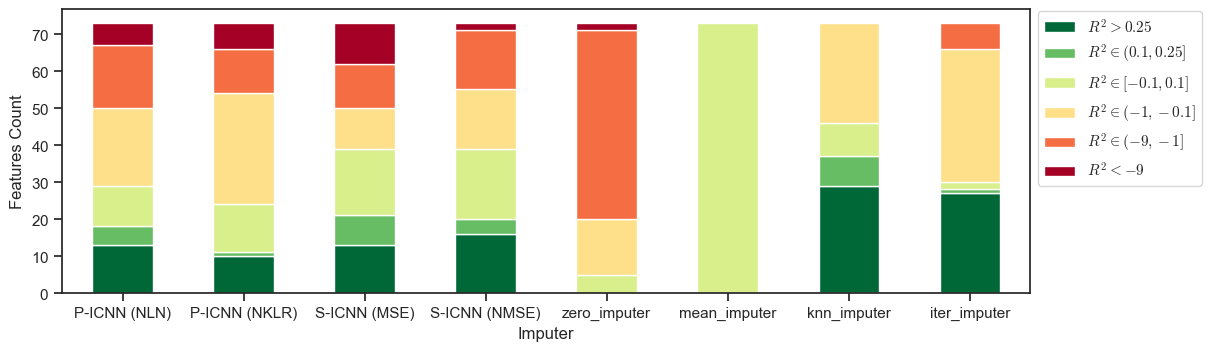

In [133]:
ax = R_bins.iloc[:, :].plot(y=R_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 2, fig_height_in * 2)
ax.get_figure().savefig(f"{RESULTS_DIR}/R2_bins.pdf")

In [134]:
final_models_filtered_features_stats_df

,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,...,"$r_\text{log}(SE, \hat{\sigma}^2)$ bin",$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin
100,P-ICNN (NLN),blood_chemistry.albumin,-1.065975,0.035345,0.124655,0.176013,0.096755,-1.010949,0.033702,-0.991472,...,"$r \in [-0.1, 0.1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$"
101,P-ICNN (NLN),blood_chemistry.aniongap,-0.281805,0.025836,0.075377,0.135074,0.054374,-0.254286,0.024859,-0.252764,...,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
102,P-ICNN (NLN),blood_chemistry.bicarbonate,-0.794584,0.024299,0.049054,0.117058,0.043375,-0.782242,0.023419,-0.806176,...,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$"
103,P-ICNN (NLN),blood_chemistry.bun,-0.551618,0.065581,0.101365,0.137159,0.015340,-0.516975,0.063854,-0.518125,...,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$"
104,P-ICNN (NLN),blood_chemistry.calcium,-1.649200,0.010721,-0.017364,0.015623,-0.022945,-1.664148,0.010656,-1.636810,...,"$r \in [-0.1, 0.1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,iter_imputer,vital.sbp,0.452593,0.007647,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,$R^2 > 0.25$,NA,NA,NA,NA,NA,NA,NA,NA
1396,iter_imputer,vital.sbp_ni,0.820376,0.002518,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,$R^2 > 0.25$,NA,NA,NA,NA,NA,NA,NA,NA
1397,iter_imputer,vital.spo2,-0.972564,0.001281,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,"$R^2 \in (-1, -0.1]$",NA,NA,NA,NA,NA,NA,NA,NA
1398,iter_imputer,vital.temperature,-0.918125,0.000421,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,"$R^2 \in (-1, -0.1]$",NA,NA,NA,NA,NA,NA,NA,NA


In [135]:
mse_cols = ['MSE'] + [f'MSE@P{p}' for p in PERCENTILES]
mse_cols_rename = {'MSE': 'P100'} | {f'MSE@P{p}': f'P{p}' for p in PERCENTILES}
NLN_mse_percentiles = final_models_filtered_features_stats_df.loc[final_models_filtered_features_stats_df.Imputer == 'P-ICNN (NLN)', ['Feature'] + mse_cols]
NLN_mse_percentiles = NLN_mse_percentiles.rename(columns=mse_cols_rename)
NLN_mse_percentiles.loc[:, mse_cols_rename.values()] = NLN_mse_percentiles.loc[:, mse_cols_rename.values()].apply(lambda c: c * 100 / NLN_mse_percentiles['P100'], axis=0)
NLN_mse_percentiles['Feature'] = NLN_mse_percentiles.Feature.map(variable_map)
NLN_mse_percentiles = NLN_mse_percentiles.sort_values('Feature')

In [142]:
NLN_mse_percentiles.sort_values('P50').iloc[:15]['Feature']

135    FiO2_chartevents
193          NI Mean BP
184       Urine out 12h
192             Mean BP
190       vital.Glucose
182                 AKI
149           CO2 total
188        Diastolic BP
195         Systolic BP
183    renal.Creatinine
186        Urine out 6h
171                 AST
153      cbc.Hematocrit
165                  PT
159                 RBC
Name: Feature, dtype: object

In [144]:
import colorcet as cc
from scipy.stats import gaussian_kde

from bokeh.models import ColumnDataSource, FixedTicker, PrintfTickFormatter, Span
from bokeh.plotting import figure, show, curdoc
from bokeh.sampledata.perceptions import probly
from bokeh.io import output_notebook, export_svgs, export_png
output_notebook()


def ridge(category, data, scale=20):
    return list(zip([category]*len(data), scale*data))

percentiles_ = list(mse_cols_rename.values())
palette = [cc.rainbow[i*15] for i in range(len(percentiles_))]

x = np.linspace(-20, 150, 10000)

source = ColumnDataSource(data=dict(x=x))

p = figure(y_range=percentiles_[1:], width=650, height=400, 
           x_range=(-5, 120), 
           # toolbar_location=None, 
           output_backend="svg"
          )

for i, p_i in enumerate(reversed(percentiles_[1:])):
    pdf = gaussian_kde(NLN_mse_percentiles[p_i], bw_method=0.1)
    y = ridge(p_i, pdf(x))
    source.add(y, p_i)
    p.patch('x', p_i, color=palette[i], alpha=0.6, line_color="black", source=source)

p.add_layout(Span(location=100, dimension='height', line_color='red', line_width=5))

# p.y_range.start = '
p.outline_line_color = None
p.background_fill_color = "#efefef"

p.xaxis.ticker = FixedTicker(ticks=list(range(0, 110, 10)))
p.xaxis.formatter = PrintfTickFormatter(format="%d%%")
p.xaxis.axis_label = "%(Relative MSE)"
p.yaxis.axis_label = r"\[\hat{\sigma}^2\]-Percentile (Upper Threshold)"

p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"

p.xaxis.major_label_text_font_size = "10pt"
p.yaxis.major_label_text_font_size = "12pt"



p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
p.xgrid.ticker = p.xaxis.ticker

# p.axis.minor_tick_line_color = None
# p.axis.major_tick_line_color = None
# p.axis.axis_line_color = None

p.y_range.range_padding = 0.1

show(p)


Loading BokehJS ...

In [115]:
NLN_mse_percentiles

<Figure size 640x480 with 0 Axes>

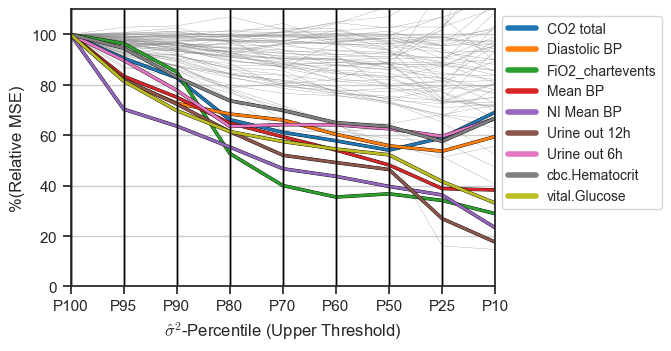

In [225]:
from matplotlib import colormaps
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe


cmap = colormaps['tab20']
grey = colormaps['Greys'](0.5)
uncertainty_aware_set = sorted(NLN_mse_percentiles.sort_values('P80').iloc[:9]['Feature'])
uncertainty_aware_set_colors = {var: cmap(2*i) for i, var in enumerate(uncertainty_aware_set)}



plt.close()
plt.gcf().clear()    
fig, ax = plt.subplots(figsize=(fig_width_in * 1.5, fig_height_in * 2.5))

pd.plotting.parallel_coordinates(NLN_mse_percentiles[~NLN_mse_percentiles.Feature.isin(uncertainty_aware_set)], 
                                      class_column='Feature', color='grey', linewidth=0.2)
pd.plotting.parallel_coordinates(NLN_mse_percentiles[NLN_mse_percentiles.Feature.isin(uncertainty_aware_set)], 
                                      class_column='Feature', color=uncertainty_aware_set_colors.values(),
                                linewidth=2,
                                path_effects=[pe.Stroke(linewidth=2.5, foreground='black'), pe.Normal()])

# remove the pandas legend
plt.gca().legend_.remove()
plt.grid(True)
plt.ylim(0, 110)
plt.xlabel(r"$\hat{\sigma}^2$-Percentile (Upper Threshold)")
plt.ylabel("%(Relative MSE)")
# plt.title("Highlighted Uncertainty-Aware Dimensions")

# add new legend
# topHandle =    mlines.Line2D([],[], color='red',   ls="-", label="Best")
# midHandleOne = mlines.Line2D([],[], color='blue',  ls="-", label="Next Best")
# lowHandle =    mlines.Line2D([],[], color='black', ls="-", label="Worst")
plt.legend(handles=[Line2D([],[], color=c,  
                           ls="-", label=var, lw=4)  for var, c in uncertainty_aware_set_colors.items()],
           loc='upper left', bbox_to_anchor=(1, 1),
           prop={'size':10})

plt.gcf().set_size_inches(fig_width_in * 1.1, fig_height_in * 2)


plt.savefig(f"{RESULTS_DIR}/LNL_uncertainty_thresholds.pdf")
plt.show()


In [216]:
var_map_r = {label: feature for feature, label in variable_map.items()}

NLN_mse_percentiles.sort_values('P60').iloc[:8]['Feature'].map(var_map_r).tolist()

['blood_gas.fio2_chartevents',
 'vital.mbp_ni',
 'renal_out.uo_rt_12hr',
 'vital.mbp',
 'vital.glucose',
 'blood_gas.totalco2',
 'vital.dbp',
 'enzymes.ast']

In [209]:

_t = all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                             (all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[:1])) & 
                                  (all_models_features_stats_df.abundance > 0.001))]

features = _t.Feature.tolist()
_t

,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,...,$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin,abundance
131,ICNN_NLN,blood_gas.calcium,-3.058477,0.008011,-0.003401,0.651646,0.079228,-2.804497,0.007417,-2.770391,...,"$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$",0.016567
133,ICNN_NLN,blood_gas.chloride,-574.500699,1.048001,-0.063340,0.396792,0.131592,-570.285681,1.024443,-618.228188,...,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,0.003903
135,ICNN_NLN,blood_gas.fio2_chartevents,0.425382,0.022148,0.396857,0.376020,0.401129,0.448164,0.021354,0.490292,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.022110
143,ICNN_NLN,blood_gas.ph,-46.273476,0.004844,-0.255647,0.387015,-0.153658,-43.910740,0.004600,-44.794525,...,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,0.034355
146,ICNN_NLN,blood_gas.so2,-5.722263,0.003962,0.020787,0.328732,0.016596,-5.222391,0.003650,-5.500941,...,"$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$",0.007209
148,ICNN_NLN,blood_gas.temperature,-17.231531,0.007028,0.030670,0.377357,0.075729,-13.035745,0.005521,-13.051703,...,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,0.006342
149,ICNN_NLN,blood_gas.totalco2,0.365834,0.010889,0.228080,0.374693,0.201060,0.413245,0.009864,0.443627,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,"$R^2 \in (0.1, 0.25]$","$R^2 \in [-0.1, 0.1]$",0.034184
150,ICNN_NLN,cardiac_marker.ck_mb,-7.518731,0.108268,0.269482,0.324592,0.143484,-7.072984,0.103691,-6.896081,...,"$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$",0.007445
153,ICNN_NLN,cbc.hematocrit,0.421010,0.008246,0.205522,0.306155,0.208169,0.454605,0.007799,0.526089,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,0.103502
163,ICNN_NLN,coagulation.fibrinogen,-1.270102,0.101440,0.096714,0.308926,0.129352,-0.976510,0.090749,-0.871566,...,"$R^2 \in (-9, -1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$",0.006099


In [233]:
n_test_censored.loc['cbc.hematocrit']

4413

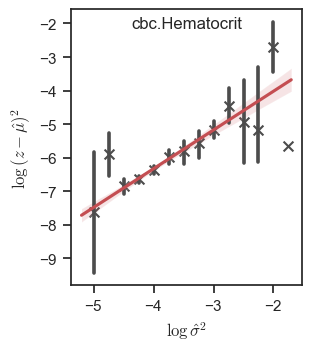

In [228]:
NLN_X_var_stats_df = prob_models_X_var_stats_df[prob_models_X_var_stats_df.Imputer == 'ICNN_NLN'].copy()
NLN_X_var_stats_df["log(SE)"] = np.log(NLN_X_var_stats_df["SE"])
NLN_X_var_stats_df[r'$\log{\hat{\sigma}^2}$'] = np.log(NLN_X_var_stats_df[r'$\hat{\sigma}^2$'])


NLN_X_var_stats_VARS = ['blood_gas.calcium',
 'blood_gas.chloride',
 'blood_gas.fio2_chartevents', # 2 *
 'blood_gas.ph', #3
 'blood_gas.so2',
 'blood_gas.temperature',
 'blood_gas.totalco2',
 'cardiac_marker.ck_mb', #7
 'cbc.hematocrit', # 8 *
 'coagulation.fibrinogen', #9
 'enzymes.bilirubin_indirect', #10
 'renal_aki.aki_binary',
 'renal_aki.aki_stage_smoothed',
 'vital.dbp',
 'vital.glucose', #14
 'vital.mbp', #
 'vital.mbp_ni',
 'vital.sbp',
 'vital.sbp_ni'] #18

p = sns.regplot(data=NLN_X_var_stats_df[NLN_X_var_stats_df.Feature == NLN_X_var_stats_VARS[8]], 
            y="log(SE)", x=r'$\log{\hat{\sigma}^2}$',
            # y="SE", x=r'$\hat{\sigma}^2$',

             x_bins=np.arange(-5, -0, 0.25), 
            # x_estimator=np.median,
            order=1,
            # lowess=True,
               ci=95, 
            marker="x", color=".3", 
                line_kws=dict(color="r"),
)
p.set_ylabel(r'$\log{(z - \hat{\mu})^2}$')

p.set_title(variable_map[NLN_X_var_stats_VARS[8]], y=1.0, pad=-14)

p.get_figure().set_size_inches(fig_width_in * 0.5, fig_height_in * 2)
p.get_figure().savefig(f"{RESULTS_DIR}/LNL_se_var_hematocrit.pdf")

In [234]:
all_models_features_stats_df.columns

Index(['Imputer', 'Feature', '$R^2$', 'MSE',
       '$r_\text{Spearman}(SE, \hat{\sigma}^2)$',
       '$r_\text{Pearson}(SE, \hat{\sigma}^2)$',
       '$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$', '$R^2@P95$', 'MSE@P95',
       '$R^2@P90$', 'MSE@P90', '$R^2@P80$', 'MSE@P80', '$R^2@P70$', 'MSE@P70',
       '$R^2@P60$', 'MSE@P60', '$R^2@P50$', 'MSE@P50', '$R^2@P25$', 'MSE@P25',
       '$R^2@P10$', 'MSE@P10', 'LN', '$r(SE, \hat{\sigma}^2)$ bin',
       '$r_\text{log}(SE, \hat{\sigma}^2)$ bin', '$R^2$ bin', '$R^2@P95$ bin',
       '$R^2@P90$ bin', '$R^2@P80$ bin', '$R^2@P70$ bin', '$R^2@P60$ bin',
       '$R^2@P50$ bin', '$R^2@P25$ bin', '$R^2@P10$ bin', 'abundance'],
      dtype='object')

In [235]:
all_models_features_stats_df[all_models_features_stats_df.Imputer == 'ICNN_NLN'].set_index('Feature')[[r'$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$', 'Imputer']].loc[NLN_X_var_stats_VARS[0]]#.sort_values(ascending=False)

$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$    0.079228
Imputer                                       ICNN_NLN
Name: blood_gas.calcium, dtype: object

In [236]:
NLN_X_var_stats_df[NLN_X_var_stats_df.Feature == NLN_X_var_stats_VARS[0]].shape

(672, 7)

In [146]:
np.arange(-12, -1, 1)

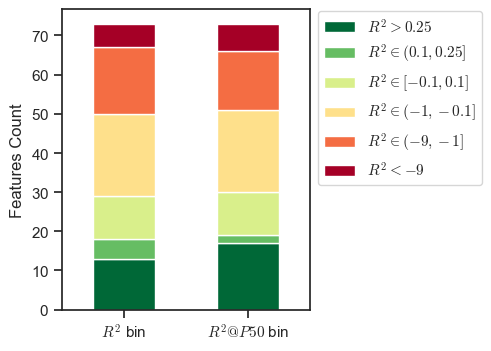

In [242]:
# final_models_filtered_features_stats_df.columns
r2_bin_cols = [r'$R^2$ bin'] + [fr'$R^2@P{p}$ bin' for p in PERCENTILES]
# r2_bin_cols_rename = {'MSE': 'P100'} | {f'MSE@P{p}': f'P{p}' for p in PERCENTILES}
NLN_R2_bins_percentiles = final_models_filtered_features_stats_df.loc[final_models_filtered_features_stats_df.Imputer == 'P-ICNN (NLN)', ['Feature'] + r2_bin_cols]
NLN_R2_bins_percentiles = NLN_R2_bins_percentiles.set_index('Feature')
NLN_R2_bins_dist_percentiles = {col: NLN_R2_bins_percentiles.groupby(col)[col].count() for col in r2_bin_cols}
NLN_R2_bins_dist_percentiles = pd.DataFrame(NLN_R2_bins_dist_percentiles)[[r2_bin_cols[0], r2_bin_cols[6]]].transpose()
NLN_R2_bins_dist_percentiles = NLN_R2_bins_dist_percentiles[R_classes]
ax = NLN_R2_bins_dist_percentiles.iloc[:, :].plot(y=R_classes, kind="bar", rot=0, 
                                                  stacked=True, colormap='RdYlGn_r', ylabel='Features Count', width=0.5)
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 0.8 , fig_height_in * 2)
ax.get_figure().savefig(f"{RESULTS_DIR}/NLN_R2_bins_percentiles.pdf")



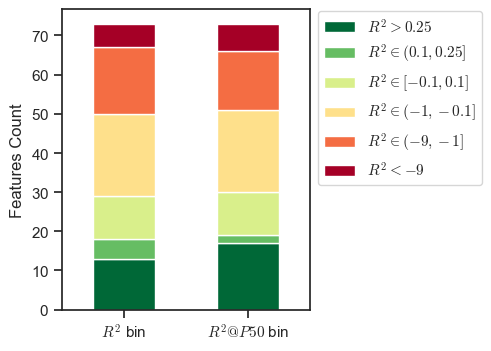

In [255]:
# final_models_filtered_features_stats_df.columns
r2_bin_cols = [r'$R^2$ bin'] + [fr'$R^2@P{p}$ bin' for p in PERCENTILES]
# r2_bin_cols_rename = {'MSE': 'P100'} | {f'MSE@P{p}': f'P{p}' for p in PERCENTILES}
NLN_R2_bins_percentiles = final_models_filtered_features_stats_df.loc[final_models_filtered_features_stats_df.Imputer == 'P-ICNN (NLN)', ['Feature'] + r2_bin_cols]
NLN_R2_bins_percentiles = NLN_R2_bins_percentiles.set_index('Feature')
NLN_R2_bins_dist_percentiles = {col: NLN_R2_bins_percentiles.groupby(col)[col].count() for col in r2_bin_cols}
NLN_R2_bins_dist_percentiles = pd.DataFrame(NLN_R2_bins_dist_percentiles)[[r2_bin_cols[0], r2_bin_cols[6]]].transpose()
NLN_R2_bins_dist_percentiles = NLN_R2_bins_dist_percentiles[R_classes]
ax = NLN_R2_bins_dist_percentiles.iloc[:, :].plot(y=R_classes, kind="bar", rot=0, 
                                                  stacked=True, colormap='RdYlGn_r', ylabel='Features Count', width=0.5)
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 0.8 , fig_height_in * 2)
ax.get_figure().savefig(f"{RESULTS_DIR}/NLN_R2_bins_percentiles.pdf")



In [253]:
r2_bin_cols

['$R^2$ bin',
 '$R^2@P95$ bin',
 '$R^2@P90$ bin',
 '$R^2@P80$ bin',
 '$R^2@P70$ bin',
 '$R^2@P60$ bin',
 '$R^2@P50$ bin',
 '$R^2@P25$ bin',
 '$R^2@P10$ bin']